Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 60)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.wsd import lesk
import syllables
import wordfreq
lemmatizer = WordNetLemmatizer() 
from data.InferSent.models import InferSent
import csv
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import rankdata, pearsonr, spearmanr, stats
from itertools import combinations
import pickle as pkl
from transformers import BertTokenizer
import json
import matplotlib.pyplot as plt
import os
import ast
import textstat
import inspect
import gensim
import stanfordnlp
from utils import *
from bs4 import BeautifulSoup
import re
import readability

[nltk_data] Downloading package wordnet to /Users/pickle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pickle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pickle/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pickle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data

In [2]:
lcp_single_train = pd.read_csv('./data/CompLex/train/lcp_single_train.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)
lcp_multi_train = pd.read_csv('./data/CompLex/train/lcp_multi_train.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)

In [2]:
lcp_single_trial = pd.read_csv('./data/CompLex/trial/lcp_single_trial.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)
lcp_multi_trial = pd.read_csv('./data/CompLex/trial/lcp_multi_trial.tsv', encoding='utf-8', sep='\t', quoting=csv.QUOTE_NONE)

Preprocessing

In [335]:
lcp_single_train[lcp_single_train.id=='391FPZIE4CM4SSUCPAZMQ77RW2MHUD']

id corpus sentence      token  complexity
2367  391FPZIE4CM4SSUCPAZMQ77RW2MHUD  bible   #NAME?  deliverer         0.5

In [336]:
lcp_single_train = lcp_single_train[lcp_single_train.id != '391FPZIE4CM4SSUCPAZMQ77RW2MHUD']

In [337]:
lcp_single_train[lcp_single_train.id=='3UY4PIS8QRLGTRPPQKKFKPZQ7HB1NK']

id  corpus  \
3620  3UY4PIS8QRLGTRPPQKKFKPZQ7HB1NK  biomed   

                                               sentence        token  \
3620  To avoid such deleterious outcomes, surveillan...  checkpoints   

      complexity  
3620         0.2

In [338]:
lcp_single_train.loc[3190, 'sentence'] = 'To avoid such deleterious outcomes, surveillance systems (‚“checkpoints‚”) exist to sense meiotic errors and eliminate cells containing unresolved defects.'

In [339]:
lcp_single_train = lcp_single_train[lcp_single_train.token.notna()]

Binning

In [341]:
lcp_single_train['class'] = pd.cut(lcp_single_train.complexity, labels=[1,2,3,4,5], bins=[0,0.2,0.4,0.6,0.8,1], include_lowest=True)p
lcp_multi_train['class'] = pd.cut(lcp_multi_train.complexity, labels=[1,2,3,4,5], bins=[0,0.2,0.4,0.6,0.8,1], include_lowest=True)

In [342]:
lcp_single_train.groupby(['corpus','class']).size()

corpus    class
bible     1         631
          2        1424
          3         464
          4          51
          5           3
biomed    1         518
          2        1403
          3         488
          4         155
          5           9
europarl  1         568
          2        1579
          3         341
          4          24
          5           0
dtype: int64

In [343]:
lcp_multi_train.groupby(['corpus','class']).size()

corpus    class
bible     1         59
          2        226
          3        192
          4         28
          5          0
biomed    1         25
          2        134
          3        205
          4        139
          5         11
europarl  1         18
          2        279
          3        185
          4         16
          5          0
dtype: int64

In [344]:
dev_sets_single = {}
train = pd.DataFrame(columns=lcp_single_train.columns)
dev = pd.DataFrame(columns=lcp_single_train.columns)
for (corpus, cls), group in lcp_single_train.groupby(['corpus','class']):
    if len(group) == 2:
        t = group.iloc[0:1]
        d = group.iloc[1:2]
    else:
        t, d = train_test_split(group, test_size=0.1)
    train = train.append(t)
    dev = dev.append(d)
    if corpus in dev_sets_single:
        dev_sets_single[corpus][cls] = t, d
    else:
        dev_sets_single[corpus] = {cls: (t, d)}
lcp_single_train = train
lcp_single_dev = dev

In [345]:
dev_sets_multi = {}
train = pd.DataFrame(columns=lcp_multi_train.columns)
dev = pd.DataFrame(columns=lcp_multi_train.columns)
for (corpus, cls), group in lcp_multi_train.groupby(['corpus','class']):
    if len(group) == 2:
        t = group.iloc[0:1]
        d = group.iloc[1:2]
    else:
        t, d = train_test_split(group, test_size=0.1)
    train = train.append(t)
    dev = dev.append(d)
    if corpus in dev_sets_multi:
        dev_sets_multi[corpus][cls] = t, d
    else:
        dev_sets_multi[corpus] = {cls: (t, d)}
lcp_multi_train = train
lcp_multi_dev = dev

In [346]:
lcp_single_train.shape, lcp_single_dev.shape

((6885, 6), (773, 6))

In [347]:
lcp_single_train['corpus'].value_counts()

biomed      2314
bible       2312
europarl    2259
Name: corpus, dtype: int64

In [348]:
lcp_single_dev['corpus'].value_counts()

bible       261
biomed      259
europarl    253
Name: corpus, dtype: int64

In [349]:
lcp_multi_train.shape, lcp_multi_dev.shape

((1360, 6), (157, 6))

In [350]:
lcp_multi_train['corpus'].value_counts()

biomed      460
bible       453
europarl    447
Name: corpus, dtype: int64

In [351]:
lcp_multi_dev['corpus'].value_counts()

biomed      54
bible       52
europarl    51
Name: corpus, dtype: int64

In [352]:
lcp_train = pd.concat([lcp_single_train, lcp_multi_train])
lcp_dev = pd.concat([lcp_single_dev, lcp_multi_dev])

In [353]:
lcp_train.shape, lcp_dev.shape

((8245, 6), (930, 6))

In [354]:
lcp_train['corpus'].value_counts()

biomed      2774
bible       2765
europarl    2706
Name: corpus, dtype: int64

In [355]:
lcp_dev['corpus'].value_counts()

bible       313
biomed      313
europarl    304
Name: corpus, dtype: int64

In [621]:
lcp_single_train_2_reduced = pd.DataFrame(columns=lcp_single_train.columns)
for (corpus, cls), group in lcp_single_train.groupby(['corpus','class']):
    if cls == 2:
        half_group, _ = train_test_split(group, test_size=0.5)
        lcp_single_train_2_reduced = lcp_single_train_2_reduced.append(half_group)
    else:
        lcp_single_train_2_reduced = lcp_single_train_2_reduced.append(group)

In [623]:
lcp_single_train_2_reduced.groupby(['corpus','class']).size()

corpus    class
bible     1        567
          2        640
          3        417
          4         45
          5          2
biomed    1        466
          2        631
          3        439
          4        139
          5          8
europarl  1        511
          2        710
          3        306
          4         21
          5          0
dtype: int64

In [1889]:
tmp = lcp_single_train
lcp_single_train = lcp_single_train_2_reduced

In [1933]:
lcp_single_train = tmp

In [358]:
lcp_single_train.to_pickle('./data/lcp_single_train.pkl')
lcp_single_dev.to_pickle('./data/lcp_single_dev.pkl')

In [ ]:
lcp_multi_train.to_pickle('./data/lcp_multi_train.pkl')
lcp_multi_dev.to_pickle('./data/lcp_multi_dev.pkl')

In [2]:
lcp_single_train = pkl.load(open('./data/lcp_single_train.pkl', 'rb'))
lcp_single_dev = pkl.load(open('./data/lcp_single_dev.pkl', 'rb'))
lcp_multi_train = pkl.load(open('./data/lcp_multi_train.pkl', 'rb'))
lcp_multi_dev = pkl.load(open('./data/lcp_multi_dev.pkl', 'rb'))

# Baseline Models

## Baseline System (Shardlow)

Handcrafted
- Note: unclear if wordfreq library is what Shardlow used.

In [45]:
def handcrafted(data):
    word_frequency = data['token'].apply(lambda x: wordfreq.word_frequency(str(x), 'en'))
    word_length = data['token'].str.len()
    syllable_count = data['token'].apply(lambda x: syllables.estimate(str(x)))
    return word_frequency, word_length, syllable_count

In [1936]:
single_train_word_frequency, single_train_word_length, single_train_syllable_count = handcrafted(lcp_single_train)
single_dev_word_frequency, single_dev_word_length, single_dev_syllable_count = handcrafted(lcp_single_dev)
multi_train_word_frequency, multi_train_word_length, multi_train_syllable_count = handcrafted(lcp_multi_train)
multi_dev_word_frequency, multi_dev_word_length, multi_dev_syllable_count = handcrafted(lcp_multi_dev)

In [ ]:
df = pd.DataFrame({'word_freq': single_train_word_frequency, \
                    'word_len': single_train_word_length, \
                    'syl_count': single_train_syllable_count, \
                    'complexity': single_train_y,
                    'corpus': lcp_single_train.corpus,
                    'word': lcp_single_train.token})
df.sort_values('complexity').tail(50)

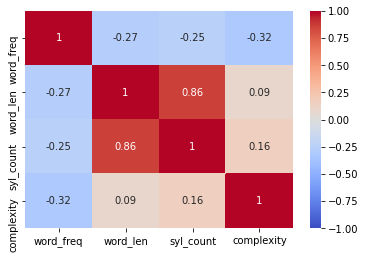

In [81]:
cor = df[['word_freq','word_len','syl_count','complexity']].corr()
sns.heatmap(cor, annot=True, vmin=-1, cmap='coolwarm')
plt.show()

Averaged Glove context + word
- Note: lowercased tokens that weren't in dictionary, but did not lemmatize them.

In [3]:
embeddings_dict = {}

In [4]:
with open("./data/glove/glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_dict[word] = coefs

400000it [01:06, 6050.56it/s]


In [412]:
def glove_word(data, embeddings_dict, lower=True):
    embeddings = np.zeros((len(data), 300))
    y, n = 0, 0
    for i, item in enumerate(data['token']):
        if lower:
            token = str(item).lower()
        else:
            token = str(item)
        found = 0
        for sub_token in token.split():
            if sub_token in embeddings_dict:
                found += 1
                y += 1
                embeddings[i] += embeddings_dict[sub_token]
            else:
                n += 1
                embeddings[i] += np.zeros(300)
        if found > 0:
            embeddings[i] /= found
    #print('found {}, missing {}'.format(y, n))
    return embeddings

In [413]:
def glove_context(data, embeddings_dict, lower=True):
    embeddings = np.zeros((len(data), 300))
    for i, sentence in enumerate(data['sentence']):
        found = 0
        for item in word_tokenize(sentence):
            if lower:
                token = str(item).lower()
            else:
                token = str(item)
            if token in embeddings_dict:
                found += 1
                embeddings[i] += embeddings_dict[token]
        if found > 0:
            embeddings[i] /= found
    return embeddings

In [5]:
def glove(data, embeddings_dict, lower=True):
    return np.concatenate((glove_word(data, embeddings_dict, lower), \
                           glove_context(data, embeddings_dict, lower)), \
                           axis=1)

In [1999]:
single_train_glove_embeddings = glove(lcp_single_train, embeddings_dict, True)
single_dev_glove_embeddings = glove(lcp_single_dev, embeddings_dict, True)
multi_train_glove_embeddings = glove(lcp_multi_train, embeddings_dict, True)
multi_dev_glove_embeddings = glove(lcp_multi_dev, embeddings_dict, True)

In [2000]:
single_train_glove_embeddings.shape, single_dev_glove_embeddings.shape

((6499, 600), (729, 600))

In [2001]:
multi_train_glove_embeddings.shape, multi_dev_glove_embeddings.shape

((1313, 600), (151, 600))

InferSent
- Note: using V2 model trained with fastText (there is a slightly worse V1 model trained with Glove).

In [385]:
V = 1
MODEL_PATH = './data/encoder/infersent%s.pkl' % V
W2V_PATH = './data/glove/glove.6B.300d.txt'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}

In [189]:
# need to re-download ./data/fastText/crawl-300d-2M.vec (~5 GB)
V = 2
MODEL_PATH = './data/encoder/infersent%s.pkl' % V
W2V_PATH = './data/fastText/crawl-300d-2M.vec'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}

In [386]:
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
infersent.set_w2v_path(W2V_PATH)

In [387]:
single_train_sentences = lcp_single_train.sentence.tolist()
infersent.build_vocab(single_train_sentences, tokenize=True)
single_train_infersent_embeddings = infersent.encode(single_train_sentences, tokenize=True)

Found 10941(/17216) words with w2v vectors
Vocab size : 10941


In [388]:
single_dev_sentences = lcp_single_dev.sentence.tolist()
infersent.build_vocab(single_dev_sentences, tokenize=True)
single_dev_infersent_embeddings = infersent.encode(single_dev_sentences, tokenize=True)

Found 3900(/5248) words with w2v vectors
Vocab size : 3900


In [2076]:
multi_train_sentences = lcp_multi_train.sentence.tolist()
infersent.build_vocab(multi_train_sentences, tokenize=True)
multi_train_infersent_embeddings = infersent.encode(multi_train_sentences, tokenize=True)

Found 5674(/7589) words with w2v vectors
Vocab size : 5674


In [2080]:
multi_dev_sentences = lcp_multi_dev.sentence.tolist()
infersent.build_vocab(multi_dev_sentences, tokenize=True)
multi_dev_infersent_embeddings = infersent.encode(multi_dev_sentences, tokenize=True)

Found 1579(/1909) words with w2v vectors
Vocab size : 1579


In [2184]:
train_sentences = lcp_train.sentence.tolist()
infersent.build_vocab(train_sentences, tokenize=True)
train_infersent_embeddings = infersent.encode(train_sentences, tokenize=True)

Found 11743(/19099) words with w2v vectors
Vocab size : 11743


In [2186]:
dev_sentences = lcp_dev.sentence.tolist()
infersent.build_vocab(dev_sentences, tokenize=True)
dev_infersent_embeddings = infersent.encode(dev_sentences, tokenize=True)

Found 4622(/6332) words with w2v vectors
Vocab size : 4622


In [711]:
with open('./data/InferSent/single_train_infersent_embeddings.npy', 'wb') as f:
    np.save(f, single_train_infersent_embeddings)

In [712]:
with open('./data/InferSent/single_dev_infersent_embeddings.npy', 'wb') as f:
    np.save(f, single_dev_infersent_embeddings)

Linear Regression

In [5]:
def train(train_df, dev_df, corpora, features, cls=None, task='single'):
    if corpora == 'All':
        train_df_corpora_idx = slice(None)
        dev_df_corpora_idx = slice(None)
    else:
        train_df_corpora_idx = train_df.corpus == corpora
        if cls:
            dev_df_corpora_idx = (dev_df.corpus == corpora) & (dev_df['class'] == cls)
        else:
            dev_df_corpora_idx = dev_df.corpus == corpora
    train_features, dev_features = [], []
    if features == 'All' or 'HC' in features:
        train_word_frequency, train_word_length, train_syllable_count = handcrafted(train_df[train_df_corpora_idx])
        train_features.append(train_word_frequency)
        train_features.append(train_word_length)
        train_features.append(train_syllable_count)
        dev_word_frequency, dev_word_length, dev_syllable_count = handcrafted(dev_df[dev_df_corpora_idx])
        dev_features.append(dev_word_frequency)
        dev_features.append(dev_word_length)
        dev_features.append(dev_syllable_count)
    if features == 'All' or 'Glove context + word' in features:
        train_features.append(glove(train_df[train_df_corpora_idx], embeddings_dict, True))
        dev_features.append(glove(dev_df[dev_df_corpora_idx], embeddings_dict, True))
    if 'Glove context' in features:
        train_features.append(glove_context(train_df[train_df_corpora_idx], embeddings_dict, True))
        dev_features.append(glove_context(dev_df[dev_df_corpora_idx], embeddings_dict, True))
    if 'Glove word' in features:
        train_features.append(glove_word(train_df[train_df_corpora_idx], embeddings_dict, True))
        dev_features.append(glove_word(dev_df[dev_df_corpora_idx], embeddings_dict, True))
    if 'TF Summed BPE' in features:
        train_tf_summed_bpe = pkl.load(open('./data/from_discovery_or_colab/lcp_single_train_tf_summed_bpe.tsv', 'rb'))['tf_summed_bpe'].to_numpy()
        dev_tf_summed_bpe = pkl.load(open('./data/from_discovery_or_colab/lcp_single_dev_tf_summed_bpe.tsv', 'rb'))['tf_summed_bpe'].to_numpy()
        train_features.append(train_tf_summed_bpe)
        dev_features.append(dev_tf_summed_bpe)
    if features == 'All' or 'Sent' in features:
        if task == 'single':
            train_features.append(single_train_infersent_embeddings[train_df_corpora_idx])
            dev_features.append(single_dev_infersent_embeddings[dev_df_corpora_idx])
        elif task == 'multi':
            train_features.append(multi_train_infersent_embeddings[train_df_corpora_idx])
            dev_features.append(multi_dev_infersent_embeddings[dev_df_corpora_idx])
        elif task == 'All':
            train_features.append(train_infersent_embeddings[train_df_corpora_idx])
            dev_features.append(dev_infersent_embeddings[dev_df_corpora_idx])
    single_train_X = np.column_stack(train_features)
    single_train_y = train_df[train_df_corpora_idx].complexity.to_numpy()
    single_dev_X = np.column_stack(dev_features)
    single_dev_y = dev_df[dev_df_corpora_idx].complexity.to_numpy()
    model = LinearRegression()
    model.fit(single_train_X, single_train_y)
    single_dev_y_pred = model.predict(single_dev_X)
    
    #return single_dev_y, single_dev_y_pred
    return mean_absolute_error(single_dev_y, single_dev_y_pred)

## Evaluate Baseline System (Shardlow) on single-words

In [2046]:
single_dev_y_pred_lst = []

All, All

In [390]:
train(lcp_single_train, lcp_single_dev, 'All', 'All')

0.11803978956878108

In [2047]:
single_dev_y, single_dev_y_pred = train(lcp_single_train, lcp_single_dev, 'All', 'All')
single_dev_y_pred_lst.append(single_dev_y_pred)

All, bible

In [391]:
train(lcp_single_train, lcp_single_dev, 'bible', 'All')

3878553057.7442904

All, biomed

In [392]:
train(lcp_single_train, lcp_single_dev, 'biomed', 'All')

40311734.2999395

All, europarl

In [393]:
train(lcp_single_train, lcp_single_dev, 'europarl', 'All')

2512213.8986864933

Hand crafted, All

In [394]:
train(lcp_single_train, lcp_single_dev, 'All', 'HC')

0.09565680266494017

In [2048]:
single_dev_y, single_dev_y_pred = train(lcp_single_train, lcp_single_dev, 'All', 'HC')
single_dev_y_pred_lst.append(single_dev_y_pred)

Hand crafted, Bible

In [395]:
train(lcp_single_train, lcp_single_dev, 'bible', 'HC')

0.09167978951247774

In [2026]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'bible', 'HC', i))

0.13541757969812862
0.050385012234797646
0.16053103820395362
0.32185550850679756
0.5588437613926215


Hand crafted, biomed

In [396]:
train(lcp_single_train, lcp_single_dev, 'biomed', 'HC')

0.1114428544121637

In [2027]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'biomed', 'HC', i))

0.14666218669271525
0.05863652114946615
0.1473116571849949
0.30044155366392433
0.4069656830135426


Hand crafted, europarl

In [397]:
train(lcp_single_train, lcp_single_dev, 'europarl', 'HC')

0.08086618637410779

In [2028]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'europarl', 'HC', i))

0.10980904905116647
0.041749782037800304
0.1563559751002285
0.31564915052151793


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

Glove context + word, All

In [15]:
train(lcp_single_train, lcp_single_dev, 'All', 'Glove context + word')

0.07229072426132284

In [2049]:
single_dev_y, single_dev_y_pred = train(lcp_single_train, lcp_single_dev, 'All', 'Glove context + word')
single_dev_y_pred_lst.append(single_dev_y_pred)

Glove context + word, bible

In [399]:
train(lcp_single_train, lcp_single_dev, 'bible', 'Glove context + word')

0.07786296179175853

In [2030]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'bible', 'Glove context + word', i))

0.09514901975442296
0.08114792792895292
0.08337751648681795
0.23111424358951724
0.2047052048975393


Glove context + word, biomed

In [400]:
train(lcp_single_train, lcp_single_dev, 'biomed', 'Glove context + word')

0.08062318688590243

In [1956]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'biomed', 'Glove context + word', i))

0.09029555908052309
0.06194072717130104
0.09095517582005154
0.13709269659128837
0.23335982082334583


Glove context + word, europarl

In [401]:
train(lcp_single_train, lcp_single_dev, 'europarl', 'Glove context + word')

0.06989786911068266

In [1962]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'europarl', 'Glove context + word', i))

0.07195222917426687
0.052346135961168244
0.07370248100206624
0.22003696714234722


ValueError: Found array with 0 sample(s) (shape=(0, 300)) while a minimum of 1 is required.

InferSent, All

In [402]:
train(lcp_single_train, lcp_single_dev, 'All', 'Sent')

0.1458943365374553

In [2050]:
single_dev_y, single_dev_y_pred = train(lcp_single_train, lcp_single_dev, 'All', 'Sent')
single_dev_y_pred_lst.append(single_dev_y_pred)

InferSent, bible

In [403]:
train(lcp_single_train, lcp_single_dev, 'bible', 'Sent')

1.0211789209184854

In [2031]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'bible', 'Sent', i))

286.99141038090823
267.1898176179698
289.4871707030199
315.3752303133082
212.339794921875


InferSent, biomed

In [404]:
train(lcp_single_train, lcp_single_dev, 'biomed', 'Sent')

219.48819131702368

In [2032]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'biomed', 'Sent', i))

0.2341312359990645
0.1812383278897367
0.1994879726494682
0.3436993218909925
0.3614150583744049


InferSent, europarl

In [405]:
train(lcp_single_train, lcp_single_dev, 'europarl', 'Sent')

0.14685966095611228

In [2033]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'europarl', 'Sent', i))

61.47941798351564
56.99250423512511
59.29483684680775
23.150848140220088


ValueError: Found array with 0 sample(s) (shape=(0, 4096)) while a minimum of 1 is required.

Context, All

In [1963]:
train(lcp_single_train, lcp_single_dev, 'All', 'Context')

0.09887410978631177

In [1975]:
single_dev_y, single_dev_y_pred = train(lcp_single_train, lcp_single_dev, 'All', 'Context')
single_dev_y_pred_lst.append(single_dev_y_pred)

Context, bible

In [1964]:
train(lcp_single_train, lcp_single_dev, 'bible', 'Context')

0.1064826476933539

In [1965]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'bible', 'Context', i))

0.1346667845832076
0.06212156130875173
0.16555830960044715
0.36019944536667015
0.5755820553562527


Context, biomed

In [1966]:
train(lcp_single_train, lcp_single_dev, 'biomed', 'Context')

0.12964682919311815

In [1967]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'biomed', 'Context', i))

0.16711180111749835
0.07645193400348463
0.17108425891212092
0.3270726976792298
0.49270055885475045


Context, europarl

In [1968]:
train(lcp_single_train, lcp_single_dev, 'europarl', 'Context')

0.08312781478309304

In [1969]:
for i in range(1, 5+1):
    print(train(lcp_single_train, lcp_single_dev, 'europarl', 'Context', i))

0.11428680499786581
0.055656328741233184
0.14156497455335026
0.2561717349206955


ValueError: Found array with 0 sample(s) (shape=(0, 300)) while a minimum of 1 is required.

## Evaluate Baseline System (Shardlow) on multi-words

In [2141]:
multi_dev_y_pred_lst = []

All, All

In [2099]:
train(lcp_multi_train, lcp_multi_dev, 'All', 'All', task='multi')

0.11513568994768283

In [2142]:
multi_dev_y, multi_dev_y_pred = train(lcp_multi_train, lcp_multi_dev, 'All', 'All', task='multi')
multi_dev_y_pred_lst.append(multi_dev_y_pred)

All, bible

In [2102]:
train(lcp_multi_train, lcp_multi_dev, 'bible', 'All', task='multi')

0.1247961580205015

All, biomed

In [2103]:
train(lcp_multi_train, lcp_multi_dev, 'biomed', 'All', task='multi')

0.10761883024490856

All, europarl

In [2108]:
train(lcp_multi_train, lcp_multi_dev, 'europarl', 'All', task='multi')

0.09537307496059047

HC, All

In [2109]:
train(lcp_multi_train, lcp_multi_dev, 'All', 'HC', task='multi')

0.10734993317222921

In [2143]:
multi_dev_y, multi_dev_y_pred = train(lcp_multi_train, lcp_multi_dev, 'All', 'HC', task='multi')
multi_dev_y_pred_lst.append(multi_dev_y_pred)

HC, bible

In [2110]:
train(lcp_multi_train, lcp_multi_dev, 'bible', 'HC', task='multi')

0.10309085394118245

In [2121]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'bible', 'HC', i, task='multi'))

0.16111398369246166
0.07866683896580018
0.08213901792256009
0.2697558246989527


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

HC, biomed

In [2111]:
train(lcp_multi_train, lcp_multi_dev, 'biomed', 'HC', task='multi')

0.11174416449196839

In [2122]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'biomed', 'HC', i, task='multi'))

0.2583619204770111
0.13899535291473727
0.04080757391748568
0.14012672527539025
0.24721548710313773


HC, europarl

In [2112]:
train(lcp_multi_train, lcp_multi_dev, 'europarl', 'HC', task='multi')

0.0706520447795829

In [2123]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'europarl', 'HC', i, task='multi'))

0.22080452330510175
0.05405816018545618
0.06583619552240155
0.198564518515061


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

Glove context + word, All

In [2113]:
train(lcp_multi_train, lcp_multi_dev, 'All', 'Glove context + word', task='multi')

0.09925009005173639

In [2144]:
multi_dev_y, multi_dev_y_pred = train(lcp_multi_train, lcp_multi_dev, 'All', 'Glove context + word', task='multi')
multi_dev_y_pred_lst.append(multi_dev_y_pred)

Glove context + word, bible

In [2114]:
train(lcp_multi_train, lcp_multi_dev, 'bible', 'Glove context + word', task='multi')

0.2819842325045308

In [2124]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'bible', 'Glove context + word', i, task='multi'))

0.22218709223739583
0.3199412294526842
0.25969016439480697
0.25478123098692


ValueError: Found array with 0 sample(s) (shape=(0, 600)) while a minimum of 1 is required.

Glove context + word, biomed

In [2115]:
train(lcp_multi_train, lcp_multi_dev, 'biomed', 'Glove context + word', task='multi')

0.21026176179045825

In [2125]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'biomed', 'Glove context + word', i, task='multi'))

0.2071966165951021
0.200225253174226
0.261292063419273
0.16171260224324327
0.08914098962506539


Glove context + word, europarl

In [2116]:
train(lcp_multi_train, lcp_multi_dev, 'europarl', 'Glove context + word', task='multi')

0.1872020140552733

In [2126]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'europarl', 'Glove context + word', i, task='multi'))

0.12530357128353833
0.211598578508229
0.1677948970057814
0.09191616645580064


ValueError: Found array with 0 sample(s) (shape=(0, 600)) while a minimum of 1 is required.

Sent, All

In [2117]:
train(lcp_multi_train, lcp_multi_dev, 'All', 'Sent', task='multi')

1248.4358852412834

In [2145]:
multi_dev_y, multi_dev_y_pred = train(lcp_multi_train, lcp_multi_dev, 'All', 'Sent', task='multi')
multi_dev_y_pred_lst.append(multi_dev_y_pred)

Sent, bible

In [2118]:
train(lcp_multi_train, lcp_multi_dev, 'bible', 'Sent', task='multi')

255.3956853093832

In [2127]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'bible', 'Sent', i, task='multi'))

289.9482394263858
269.8077271199678
200.58449435158383
377.73308376736105


ValueError: Found array with 0 sample(s) (shape=(0, 4096)) while a minimum of 1 is required.

Sent, biomed

In [2119]:
train(lcp_multi_train, lcp_multi_dev, 'biomed', 'Sent', task='multi')

1064.809629866677

In [2128]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'biomed', 'Sent', i, task='multi'))

1607.8634670035547
1279.0796576345383
1059.110237684598
621.2052577046959
1915.409423828125


Sent, europarl

In [2120]:
train(lcp_multi_train, lcp_multi_dev, 'europarl', 'Sent', task='multi')

385.0988188218063

In [2129]:
for i in range(1, 5+1):
    print(train(lcp_multi_train, lcp_multi_dev, 'europarl', 'Sent', i, task='multi'))

485.89849045697383
341.22745244812165
451.2115763328202
270.42640104747954


ValueError: Found array with 0 sample(s) (shape=(0, 4096)) while a minimum of 1 is required.

## Evaluate Baseline System (Shardlow) on single-words + multi-words

In [2247]:
dev_y_pred_lst = []

All, All

In [2200]:
train(lcp_train, lcp_dev, 'All', 'All', task='All')

0.11548663607009989

In [2248]:
dev_y, dev_y_pred = train(lcp_train, lcp_dev, 'All', 'All', task='All')
dev_y_pred_lst.append(dev_y_pred)

All, bible

In [2202]:
train(lcp_train, lcp_dev, 'bible', 'All', task='All')

267613.8149265642

In [2218]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'bible', 'All', i, task='All'))

233578.19322596226
274004.7282424235
289930.09149234486
276318.72967601
183045.5366446869


All, biomed

In [2203]:
train(lcp_train, lcp_dev, 'biomed', 'All', task='All')

57571781.94611551

In [2219]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'biomed', 'All', i, task='All'))

60851767.40637285
57411792.25722137
45212813.601414025
77412054.41742696
95678052.4308427


All, europarl

In [2204]:
train(lcp_train, lcp_dev, 'europarl', 'All', task='All')

4624420.481983238

In [2220]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'europarl', 'All', i, task='All'))

4906115.116857612
4457543.881040842
4923681.249206129
4276217.059515604


ValueError: Found array with 0 sample(s) (shape=(0, 4699)) while a minimum of 1 is required.

HC, All

In [2206]:
train(lcp_train, lcp_dev, 'All', 'HC', task='All')

0.10166762293858074

In [2249]:
dev_y, dev_y_pred = train(lcp_train, lcp_dev, 'All', 'HC', task='All')
dev_y_pred_lst.append(dev_y_pred)

HC, bible

In [2205]:
train(lcp_train, lcp_dev, 'bible', 'HC', task='All')

0.0999551753902345

In [2230]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'bible', 'HC', i, task='All'))

0.1380606427912472
0.05481310862132293
0.1395508859911489
0.2997867125647246
0.5584218789052744


HC, biomed

In [2207]:
train(lcp_train, lcp_dev, 'biomed', 'HC', task='All')

0.12120308098659728

In [2231]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'biomed', 'HC', i, task='All'))

0.15579920862968225
0.07491162975781232
0.12121006787920341
0.2713374639675451
0.3771588637136421


HC, europarl

In [2208]:
train(lcp_train, lcp_dev, 'europarl', 'HC', task='All')

0.07704883985312827

In [2232]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'europarl', 'HC', i, task='All'))

0.11228370098049782
0.04575320924428665
0.12762974805893282
0.27920112857638724


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

Glove context + word, All

In [2209]:
train(lcp_train, lcp_dev, 'All', 'Glove context + word', task='All')

0.08394105623590585

In [2250]:
dev_y, dev_y_pred = train(lcp_train, lcp_dev, 'All', 'Glove context + word', task='All')
dev_y_pred_lst.append(dev_y_pred)

Glove context + word, bible

In [2210]:
train(lcp_train, lcp_dev, 'bible', 'Glove context + word', task='All')

0.09477023348123662

In [2239]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'bible', 'Glove context + word', i, task='All'))

0.09942731007765834
0.0836239198656615
0.09594417495750765
0.24400598149812472
0.26312939144317626


Glove context + word, biomed

In [2211]:
train(lcp_train, lcp_dev, 'biomed', 'Glove context + word', task='All')

0.09605404704105337

In [2240]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'biomed', 'Glove context + word', i, task='All'))

0.1179141448843547
0.0716381725480759
0.0983991547702659
0.16681409428342212
0.19445278261238574


Glove context + word, europarl

In [2212]:
train(lcp_train, lcp_dev, 'europarl', 'Glove context + word', task='All')

0.07311182931075803

In [2241]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'europarl', 'Glove context + word', i, task='All'))

0.08905442273159737
0.06075818098157429
0.0857035852476434
0.208553980672127


ValueError: Found array with 0 sample(s) (shape=(0, 600)) while a minimum of 1 is required.

Sent, All

In [2213]:
train(lcp_train, lcp_dev, 'All', 'Sent', task='All')

0.1491015555086368

In [2251]:
dev_y, dev_y_pred = train(lcp_train, lcp_dev, 'All', 'Sent', task='All')
dev_y_pred_lst.append(dev_y_pred)

Sent, bible

In [2214]:
train(lcp_train, lcp_dev, 'bible', 'Sent', task='All')

13.330142029572823

In [2243]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'bible', 'Sent', i, task='All'))

12.851738071242272
14.342610454534707
11.38959242604175
11.70188080566244
16.95448989868164


Sent, biomed

In [2215]:
train(lcp_train, lcp_dev, 'biomed', 'Sent', task='All')

24.446626044372056

In [2244]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'biomed', 'Sent', i, task='All'))

20.70248491634034
28.537381175105228
19.05864915182364
24.067636745860913
11.243062195954499


Sent, europarl

In [2216]:
train(lcp_train, lcp_dev, 'europarl', 'Sent', task='All')

69.75404826986971

In [2245]:
for i in range(1, 5+1):
    print(train(lcp_train, lcp_dev, 'europarl', 'Sent', i, task='All'))

57.135588752360675
73.3923890035033
71.93705874360408
59.72890211526483


ValueError: Found array with 0 sample(s) (shape=(0, 4096)) while a minimum of 1 is required.

Inspecting Shared Instances

In [2155]:
dev_y_pred_lst = multi_dev_y_pred_lst
dev_y = multi_dev_y
lcp_dev = lcp_multi_dev

In [2252]:
dev_y_ranks = [rankdata(np.abs(dev_y-item)) for item in dev_y_pred_lst]
dev_y_ranks = [np.array([(len(item) - rankdata(item).astype(int)).tolist()]) for item in dev_y_ranks]

In [2253]:
ranking_similarities = np.zeros((len(dev_y_ranks),len(dev_y_ranks)))
for i in range(len(dev_y_ranks)):
    for j in range(len(dev_y_ranks)):
        ranking_similarities[i, j] = ndcg_score(dev_y_ranks[i], dev_y_ranks[j])
ranking_similarities

array([[1.        , 0.90578569, 0.90909879, 0.92418313],
       [0.91270907, 1.        , 0.91288879, 0.91882107],
       [0.91431852, 0.91926781, 1.        , 0.91204329],
       [0.93384813, 0.91044545, 0.913162  , 1.        ]])

In [2171]:
features = ['All', 'HC', 'Glove context + word', 'Sent']
shared_instances = set()
for (i, feature_i), (j, feature_j) in combinations(enumerate(features), 2):
    print('feature sets: {}, {}'.format(feature_i,  feature_j))
    print('    top-50 shared instances')
    top = 50
    shared_instances_portion = np.intersect1d(np.argsort(dev_y_ranks[i][0])[:top], np.argsort(dev_y_ranks[j][0])[:top])
    shared_instances.update(shared_instances_portion)
    lcp_dev_portion = lcp_dev.iloc[shared_instances_portion]
    if len(lcp_dev_portion):
        for i, row in lcp_dev_portion.iterrows():
            print('        ', row.sentence, row.token, row.complexity)
    else:
        print('        ', None)
    print('\n')
lcp_dev_shared_instances = lcp_dev.iloc[sorted(list(shared_instances))]

feature sets: All, HC
    top-50 shared instances
         Have I brought them forth, that you should tell me, 'Carry them in your bosom, as a nurse carries a nursing infant, to the land which you swore to their fathers?' nursing infant 0.15000000000000002
         But it displeased Jonah exceedingly, and he was angry. displeased Jonah 0.25
         then Yahweh will make your plagues wonderful, and the plagues of your seed, even great plagues, and of long continuance, and severe sicknesses, and of long continuance. severe sicknesses 0.325
         The king spoke and said to the wise men of Babylon, Whoever shall read this writing, and show me its interpretation, shall be clothed with purple, and have a chain of gold about his neck, and shall be the third ruler in the kingdom. third ruler 0.2333333333333333
         and whoever doesn't fall down and worship shall be cast into the midst of a burning fiery furnace. fiery furnace 0.2368421052631579
         A wicked messenger falls into tr

In [2169]:
lcp_dev_shared_instances

id    corpus  \
39    3HUR21WDDUPIVREW4FEXWE1YGGGXYK     bible   
70    338GLSUI43B4ZJB25FGM8LDQVQPFSY     bible   
42    3L4YG5VW9NS1ZAEOHJQ7PMO5IAZDDR     bible   
200   306W7JMRYYYW3IKDMFOL84M44YQ8B9     bible   
84    39XCQ6V3KY47AOKGSQ0AL4QLO7E56J     bible   
139   3WKGUBL7SZM7XQJN1PN25V24E684LL     bible   
201   356TQKY9XFX916HN9YC53208L8Z87N     bible   
268   35NNO802AVWRTXLNYR5LCOGCOJ8NIK     bible   
241   31JUPBOORN48GR6PDSDFM7I9GS38LV     bible   
109   3UY4PIS8QRLGTRPPQKKFKPZQ7HXN1S     bible   
116   3YD0MU1NC21NKUA26WWJZT63BWZA7T     bible   
93    35A1YQPVFEGN38FHUR9ZI7GQXY9I5Q     bible   
341   3V0TR1NRVA2Q17SJ4YYCWHMTKU9A49     bible   
407   3ECKRY5B1QWLAMZ61FGF7BNLYXGIZW     bible   
203   3XT3KXP24ZYJMCFVZAJ4ADUQTTJ6IT     bible   
380   3AFT28WXLF29BILZZ65YRDGHETDIOU     bible   
448   337F8MIIMZDU0UU1CW1J7BAGB8W40B     bible   
430   302U8RURJZ1WF35NXY44RD66WL4VNP     bible   
443   3HXK2V1N4KFH8KQZMK7YZO0YYBPG2U     bible   
462   3YGYP1364194MWO6OEZUQGH3BG3RN6    biomed   
478   3MVY4USGB6NO9ADS6NM7BIQIBJSIS5    biomed   
551   3R5OYNIC2C9H5WDB8IHHUKNGZG0PTC    biomed   
528   3NCN4N1H1GHH6P7HSHD4Q1CZTU0BND    biomed   
508   3LN50BUKPVBTMJ56Z9FQ8TDZ53FLP6    biomed   
673   38G0E1M85M59ATPWUZGQ58Y04I8UVT    biomed   
784   3JTPR5MTZSCE9355UUUBVNV3P38K5F    biomed   
626   3X52SWXE0X5Q3O81YI0MX4V84R4WCW    biomed   
710   34ZTTGSNJXOC0ZNV81FHG6A2TISHQM    biomed   
618   3HA5ODM5KASTVGXS5ULQQ7GCJLOVSF    biomed   
752   3OQQD2WO8I6KPTSDG8L63AI6J3T3IY    biomed   
947   391FPZIE4CM4SSUCPAZMQ77RW3YUH4    biomed   
866   3IZVJEBJ6AK5H245ZE7QA8XGP7X6Z4    biomed   
923   3DWGDA5POF4T1WYYSB66U6T3TLAV1U    biomed   
778   341H3G5YF0EA3RIQXPR917NPC4B0ZX    biomed   
902   3QD8LUVX4XYKT34CTD90LH35LCO5XQ    biomed   
901   3TZ0XG8CBUKDFP5GOVAPHYREGZY89C    biomed   
850   34R0BODSP1ZBN3DVY8J8XSIY56DE5Q    biomed   
905   37MQ8Z1JQEWHUBBZGQT46O7238R2YS    biomed   
960   3RSBJ6YZECQP1RJ9YYZDOG3PY2XOFN    biomed   
957   338431Z1FLFM4HOIPTZ755H81Q8ROL    biomed   
981   31MBOZ6PAORASUW2U4TKOTES6LNLCH  europarl   
1242  3R5LWXWHR08I90TWA9SRPEUUBMOXGO  europarl   
1268  3S4TINXCC0NZOA7TTWDH5QC4J5SBOH  europarl   
1205  3TZ0XG8CBUKDFP5GOVAPHYREG0L891  europarl   
1083  3OEWW2KGQJBS375D7S4N0G04MQ4OD1  europarl   
1019  3BO3NEOQM0HK9ERYPN0GQIWCPE8AIQ  europarl   
1147  3MYASTQBG7BVOJITM5WRPLV41RMQDB  europarl   
1074  3IHWR4LC7DD6QQYJSPG2URQHZQ8I8U  europarl   
1223  33W1NHWFYHLBJ0FHVRFJLIPU9GVTZR  europarl   
1275  3X2LT8FDHWIORLIOH6KHVIZPE168WR  europarl   
1453  3PCPFX4U40QSM3WPDBRHDLYPD42FQB  europarl   
1295  3AQN9REUTFG4XL9FDFDL27Y6003DY1  europarl   
1433  34D9ZRXCYRU93SUUUZUUUK2ZYCAASI  europarl   
1297  3IKDQS3DQE082TOW91W7WDM0PHTIC0  europarl   
1461  33NOQL7T9OZSLGNTST4OUMT7V3A8ZH  europarl   
1456  3SV8KD29L4SCGHPU1I1RKR2YQ34KZC  europarl   

                                               sentence  \
39    saying, 'Woe, woe, the great city, she who was...   
70    Deliver my soul from the sword, my precious li...   
42    Have I brought them forth, that you should tel...   
200   The godly man has perished out of the earth, a...   
84                   The honorable man, he lived in it.   
139   But it displeased Jonah exceedingly, and he wa...   
201   then Yahweh will make your plagues wonderful, ...   
268   Samuel came no more to see Saul until the day ...   
241                       It is cobra venom within him.   
109   The king spoke and said to the wise men of Bab...   
116   and whoever doesn't fall down and worship shal...   
93    A wicked messenger falls into trouble, but a t...   
341   Hezekiah had exceeding much riches and honor: ...   
407   For if by the trespass of the one, death reign...   
203   and you took your embroidered garments, and co...   
380   The altar hearth shall be twelve [cubits] long...   
448   They each took his censer, and put fire in the...   
430   The oxen likewise and the young donkeys that t...   
443   Behold, I am against those who prophesy lying ...   
462

In [1463]:
num_proper_noun_tokens = sum(1 for token in lcp_single_dev_shared_instances['token'] if token[0].isupper())
num_tokens = len(lcp_single_dev_shared_instances)
num_proper_noun_tokens, num_tokens, num_proper_noun_tokens/num_tokens

(19, 46, 0.41304347826086957)

In [1464]:
num_proper_noun_tokens = sum(1 for token in lcp_single_train['token'] if token[0].isupper())
num_tokens = len(lcp_single_train)
num_proper_noun_tokens, num_tokens, num_proper_noun_tokens/num_tokens

(1393, 6499, 0.2143406677950454)

Acronyms
	Solution: normalize text, expand known acronyms
Pronouns
	Solution: syllables

BERT

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [8]:
lcp_single_train.iloc[:10]

id corpus  \
604  3TX9T2ZCB913BHJBQWKU82WTD88WZB  bible   
195  3MD8CKRQZZN836XL9G72X90M2VMRJO  bible   
199  3BJKPTD2QCC2H9TQLAL6ZFNV0XDRTT  bible   
24   3DWNFENNE3V120VNY4BPPGPCAH2J4X  bible   
15   3TCFMTM8HEOK450W41MVS1WSWM721H  bible   
342  3GONHBMNHVY765PXMUE7Z4U2F60MZG  bible   
523  3WRAAIUSBJZHZ9GTO90HTSJRDP7XA4  bible   
370  385MDVINFCFDB2E78AH8K883UA1WJW  bible   
556  3M93N4X8HKNK4LXYO577NJ5IOX5SJD  bible   
154  3R5OYNIC2C9H5WDB8IHHUKNGZFPPTZ  bible   

                                              sentence    token  complexity  \
604                    The flame burned up the wicked.    flame    0.156250   
195  Those who sin, reprove in the sight of all, th...      sin    0.142857   
199  There will arise after them seven years of fam...    years    0.075000   
24   When his speech is charming, don't believe him...   speech    0.000000   
15   Mount Sinai, all it, smoked, because Yahweh de...     fire    0.000000   
342  because of their wickedness which they have co...  fathers    0.117647   
523                 He is their help and their shield.   shield    0.156250   
370             The princes of Zoan have become fools.    fools    0.166667   
556  For he built again the high places which Hezek...      sky    0.150000   
154  There will be a pavilion for a shade in the da...   refuge    0.075000   

    class  
604     1  
195     1  
199     1  
24      1  
15      1  
342     1  
523     1  
370     1  
556     1  
154     1

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t['sentence'])[:511], lcp_single_train.iloc[:10]))

In [43]:
single_train_tokens, single_dev_tokens, multi_train_tokens, multi_dev_tokens = [], [], [], []
for i, row in lcp_single_train.iterrows():
    single_train_tokens.append('[CLS]'+row['sentence']+'[SEP]'+row['token']+'[SEP]')
for i, row in lcp_single_dev.iterrows():
    single_dev_tokens.append('[CLS]'+row['sentence']+'[SEP]'+row['token']+'[SEP]')
for i, row in lcp_multi_train.iterrows():
    multi_train_tokens.append('[CLS]'+row['sentence']+'[SEP]'+row['token']+'[SEP]')
for i, row in lcp_multi_dev.iterrows():
    multi_dev_tokens.append('[CLS]'+row['sentence']+'[SEP]'+row['token']+'[SEP]')   

In [44]:
single_train_tokens[0]

'[CLS]The flame burned up the wicked.[SEP]flame[SEP]'

In [45]:
single_train_tokens = [tokenizer.tokenize(item)[:511] for item in single_train_tokens]
single_dev_tokens = [tokenizer.tokenize(item)[:511] for item in single_dev_tokens]
multi_train_tokens = [tokenizer.tokenize(item)[:511] for item in multi_train_tokens]
multi_dev_tokens = [tokenizer.tokenize(item)[:511] for item in multi_dev_tokens]

In [46]:
single_train_tokens[0]

['[CLS]',
 'The',
 'flame',
 'burned',
 'up',
 'the',
 'wicked',
 '.',
 '[SEP]',
 'flame',
 '[SEP]']

In [47]:
lcp_single_train.head()

id corpus  \
604  3TX9T2ZCB913BHJBQWKU82WTD88WZB  bible   
195  3MD8CKRQZZN836XL9G72X90M2VMRJO  bible   
199  3BJKPTD2QCC2H9TQLAL6ZFNV0XDRTT  bible   
24   3DWNFENNE3V120VNY4BPPGPCAH2J4X  bible   
15   3TCFMTM8HEOK450W41MVS1WSWM721H  bible   

                                              sentence   token  complexity  \
604                    The flame burned up the wicked.   flame    0.156250   
195  Those who sin, reprove in the sight of all, th...     sin    0.142857   
199  There will arise after them seven years of fam...   years    0.075000   
24   When his speech is charming, don't believe him...  speech    0.000000   
15   Mount Sinai, all it, smoked, because Yahweh de...    fire    0.000000   

    class  
604     1  
195     1  
199     1  
24      1  
15      1

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], lcp_single_train['sentence']))
dev_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts))

In [ ]:
lcp_single_train['sentence'].tolist()

In [ ]:
classes = lcp_single_train['class'].unique().tolist()
sentences = lcp_single_train['sentence'].tolist()

In [6]:
from torchnlp.datasets import imdb_dataset

In [14]:
train_data, test_data = imdb_dataset(train=True, test=True)

In [15]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

In [16]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_texts[:100]))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_texts[:100]))

In [121]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', max_length=512)

In [132]:
def data_to_json_format(data, output_path, model='bert-base-cased', do_lower_case=True):
    tokenizer = BertTokenizer.from_pretrained(model, do_lower_case=do_lower_case)
    text = data['sentence'].tolist()
    aspect = data['token'].tolist()
    labels = data['complexity'].tolist()
    with open(output_path, 'a') as f:
        for i in range(len(text)):
            line_dict = {}
            line_dict["uid"] = str(i)
            line_dict["label"] = labels[i]
            if type(text[i]) == str:
                tokenization_res = tokenizer.encode_plus(text[i], max_length=512)
                line_dict["token_id"] = tokenization_res['input_ids']
                line_dict["type_id"] = tokenization_res['token_type_ids']
                json.dump(line_dict, f)
                f.write('\n')

In [133]:
data_to_json_format(lcp_single_train, './data/lcp_single_train.json')

In [91]:
tokenizer.encode_plus(text[606], max_length=None).keys()

Token indices sequence length is longer than the specified maximum sequence length for this model (1085 > 512). Running this sequence through the model will result in indexing errors


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [98]:
len(tokenizer.encode_plus(text[708], max_length=None)['input_ids'])

21

Prepare data for preproc_std.py

In [9]:
def prepare_data_for_preproc_std(data, output_path, do_round=True, do_mask=False, do_scale=False, do_token=True):
    if do_token:
        x = data[['complexity', 'sentence', 'token']]
    else:
        x = data[['complexity', 'sentence']]
    x.insert(0, 'idx', range(len(data)))
    if do_scale:
        x['complexity'] = data['complexity_scaled']
    if do_round:
        x['complexity'] = x['complexity'].map('{:.3f}'.format)
    if do_mask:
        x['sentence'] = x[['sentence', 'token']].apply(lambda y: '[MASK]'.join(y['sentence'].split(y['token'])), axis=1)
    x.to_csv(output_path, sep='\t', index=False, header=False, encoding='utf-8')

In [ ]:
prepare_data_for_preproc_std(lcp_single_train, './data/lcp_single_train_formatted.tsv')
prepare_data_for_preproc_std(lcp_single_dev, './data/lcp_single_dev_formatted.tsv')
prepare_data_for_preproc_std(lcp_single_trial, './data/lcp_single_trial_formatted.tsv')

In [626]:
prepare_data_for_preproc_std(lcp_single_train_2_reduced, './data/lcp_single_train_2_reduced_formatted.tsv')

In [10]:
prepare_data_for_preproc_std(lcp_single_train, './data/lcp_single_train_masked.tsv', do_mask=True)
prepare_data_for_preproc_std(lcp_single_dev, './data/lcp_single_dev_masked.tsv', do_mask=True)
prepare_data_for_preproc_std(lcp_single_trial, './data/lcp_single_trial_masked.tsv', do_mask=True)

In [542]:
prepare_data_for_preproc_std(lcp_single_train, './data/lcp_single_train_scaled.tsv', do_scale=True)
prepare_data_for_preproc_std(lcp_single_dev, './data/lcp_single_dev_scaled.tsv', do_scale=True)
prepare_data_for_preproc_std(lcp_single_trial, './data/lcp_single_trial_scaled.tsv', do_scale=True)

In [5]:
prepare_data_for_preproc_std(lcp_single_train, './data/lcp_single_train_no_token.tsv', do_token=False)
prepare_data_for_preproc_std(lcp_single_dev, './data/lcp_single_dev_no_token.tsv', do_token=False)
prepare_data_for_preproc_std(lcp_single_trial, './data/lcp_single_trial_no_token.tsv', do_token=False)

Assess basic BERT MT-DNN (uncased) predictions

In [9]:
single_dev_y = lcp_single_dev['complexity'].to_numpy()

In [431]:
path = './data/from_discovery_or_colab/uncased_lcp_dev_scores_{}.json'.format(4)
results = json.load(open(path))
single_dev_y_pred = np.array(results['scores'])
print(mean_absolute_error(single_dev_y, single_dev_y_pred))

0.07058717967452238


In [63]:
lcp_single_dev['complexity_pred'] = single_dev_y_pred
idx = np.abs(lcp_single_dev['complexity']-lcp_single_dev['complexity_pred']).sort_values(ascending=False).index

What is the basic MT-DNN model struggling with? Proper nouns maybe? Yep.

In [470]:
lcp_single_dev.loc[idx].head(50).token.str.match(r'^[A-Z]').value_counts()

True     29
False    21
Name: token, dtype: int64

In [466]:
lcp_single_dev.loc[idx].token.str.match(r'^[A-Z]').value_counts()

False    615
True     158
Name: token, dtype: int64

Compare performance on proper nouns to that of basic BERT MT-DNN (cased) predictions?

In [6]:
path = './data/from_discovery_or_colab/cased_lcp_dev_scores_{}.json'.format(3)
results = json.load(open(path))
single_dev_y_pred = np.array(results['scores'])
sinlge_dev_y = lcp_single_dev['complexity'].to_numpy()
print(mean_absolute_error(sinlge_dev_y, single_dev_y_pred))

0.06211153334064622


In [7]:
lcp_single_dev['complexity_pred'] = single_dev_y_pred
idx = np.abs(lcp_single_dev['complexity']-lcp_single_dev['complexity_pred']).sort_values(ascending=False).index

In [8]:
lcp_single_dev.loc[idx].head(50).token.str.match(r'^[A-Z]').value_counts()

False    31
True     19
Name: token, dtype: int64

In [9]:
lcp_single_dev.loc[idx].token.str.match(r'^[A-Z]').value_counts()

False    615
True     158
Name: token, dtype: int64

How long do proper noun tokens tend to be?

In [64]:
lcp_single_dev_ordered = lcp_single_dev.loc[idx]

In [11]:
proper_nouns_50_idx = lcp_single_dev_ordered.head(50).token.str.match(r'^[A-Z]')
proper_nouns_50 = lcp_single_dev_ordered.head(50).loc[proper_nouns_50_idx]
proper_nouns_50

id    corpus  \
2573  3O2Y2UIUCQU6B0YU067KHZMGEWBKFL     bible   
5149  3UEBBGULPFOKEW36UKBMNMVEGNSUFB    biomed   
5134  38B7Q9C28G5QBBMSVGDRXKVNA3B69P    biomed   
6187  3JMQI2OLFZ5ALM516D4ALR0ZWGWNDI  europarl   
4777  3QD8LUVX4XYKT34CTD90LH35LBVX5N    biomed   
7078  3OKP4QVBP2X6DNL3ZZ0D56JWA0XGAJ  europarl   
2196  3VMHWJRYHVGCV0X1ZPM97TUIA3UFX5     bible   
2011  37SDSEDIN92VQK2LKIVW2S9VIMT81K     bible   
4871  3VLL1PIENQOV68A9ZATKR8J7A6YOZG    biomed   
7589  3ZUE82NE0A1MGZWTRHAHRUDPJYDF8X  europarl   
4884  3PIOQ99R7YMW2OGNS8UZVR4NIEENUB    biomed   
195   3ZLW647WALVGE8EBR50EGUBPU6L239     bible   
6156  3MJ28H2Y1E8XZUQKSMM424CC993O5Q  europarl   
4702  3K8CQCU3KE19US5SN890DFPK3UKNW5    biomed   
245   3T2EL38U0MK9MPNAD5X3JSYWH5MQXT     bible   
7231  31GN6YMHLPS6A5XXV4QMC9ZQQVASW8  europarl   
7521  3VQTAXTYN3LU1FRQPIPQ4W4T1RDUBA  europarl   
7077  3VGET1QSZ0ZKR7D571SBHI3U3GH7WI  europarl   
1263  34XASH8KLQMDS1NRZLG586SO57NPMS     bible   

                                               sentence          token  \
2573  he sent Hadoram his son to king David, to Gree...            Tou   
5149    Supplementary data are available at NAR online.            NAR   
5134  In various manipulations of the neurotrophins ...            KOs   
6187          Transparency of institutional investors (   Transparency   
4777  For example, a QTL for PROP avoidance has been...           PROP   
7078  Accession of Liechtenstein to the Agreement be...      Accession   
2196  Hezekiah prayed before Yahweh, and said, "Yahw...       Hezekiah   
2011  Cush became the father of Nimrod; he began to ...           Cush   
4871  The similarities between rheumatoid arthritis ...             RA   
7589    Robert Schuman worked closely with Jean Monnet.           Jean   
4884  Transcription of apparent 'singleton' olfactor...             Mb   
195   There will be weeping and gnashing of teeth, w...        Kingdom   
6156  The next item is the Council and Commission st...         Serbia   
4702  However, up-regulation of      Sox9 is not suf...             XX   
245   About four hundred men followed David; and two...          David   
7231  Mobilisation of the European Globalisation Adj...  Globalisation   
7521  (ET) Mr President, the decision taken on the i...             ET   
7077  Accession of Bulgaria and Romania to the Conve...      Accession   
1263  Conscience, I say, not your own, but the other...     Conscience   

      complexity class  complexity_pred  
2573    0.825000     5         0.526320  
5149    0.861111     5         0.603327  
5134    0.775000     4         0.527917  
6187    0.203125     2         0.427477  
4777    0.450000     3         0.664492  
7078    0.607143     4         0.394917  
2196    0.382353     2         0.586920  
2011    0.338235     2         0.541355  
4871    0.477273     3         0.674527  
7589    0.487500     3         0.301005  
4884    0.484375     3         0.665381  
195     0.075000     1         0.245407  
6156    0.200000     1         0.367945  
4702    0.416667     3         0.577778  
245     0.416667     3         0.256684  
7231    0.611111     4         0.453493  
7521    0.450000     3         0.605518  
7077    0.535714     3         0.384283  
1263    0.218750     2         0.367565

In [12]:
proper_nouns_50.groupby(['corpus']).get_group('bible').token.str.len().mean()

6.166666666666667

In [13]:
proper_nouns_50.groupby(['corpus']).get_group('biomed').token.str.len().mean()

2.6666666666666665

In [14]:
proper_nouns_50.groupby(['corpus']).get_group('europarl').token.str.len().mean()

7.857142857142857

In [15]:
proper_nouns_50.groupby(['corpus']).get_group('europarl')

id    corpus  \
6187  3JMQI2OLFZ5ALM516D4ALR0ZWGWNDI  europarl   
7078  3OKP4QVBP2X6DNL3ZZ0D56JWA0XGAJ  europarl   
7589  3ZUE82NE0A1MGZWTRHAHRUDPJYDF8X  europarl   
6156  3MJ28H2Y1E8XZUQKSMM424CC993O5Q  europarl   
7231  31GN6YMHLPS6A5XXV4QMC9ZQQVASW8  europarl   
7521  3VQTAXTYN3LU1FRQPIPQ4W4T1RDUBA  europarl   
7077  3VGET1QSZ0ZKR7D571SBHI3U3GH7WI  europarl   

                                               sentence          token  \
6187          Transparency of institutional investors (   Transparency   
7078  Accession of Liechtenstein to the Agreement be...      Accession   
7589    Robert Schuman worked closely with Jean Monnet.           Jean   
6156  The next item is the Council and Commission st...         Serbia   
7231  Mobilisation of the European Globalisation Adj...  Globalisation   
7521  (ET) Mr President, the decision taken on the i...             ET   
7077  Accession of Bulgaria and Romania to the Conve...      Accession   

      complexity class  complexity_pred  
6187    0.203125     2         0.427477  
7078    0.607143     4         0.394917  
7589    0.487500     3         0.301005  
6156    0.200000     1         0.367945  
7231    0.611111     4         0.453493  
7521    0.450000     3         0.605518  
7077    0.535714     3         0.384283

In [16]:
lcp_single_dev_ordered.groupby(['corpus']).get_group('bible').token.str.len().mean()

6.64367816091954

In [17]:
lcp_single_dev_ordered.groupby(['corpus']).get_group('biomed').token.str.len().mean()

7.343629343629344

In [18]:
lcp_single_dev_ordered.groupby(['corpus']).get_group('europarl').token.str.len().mean()

8.268774703557312

How high are the complexities of proper noun tokens?

In [19]:
proper_nouns_idx = lcp_single_dev_ordered.token.str.match(r'^[A-Z]')

In [20]:
lcp_single_dev_ordered.loc[proper_nouns_idx].complexity.describe()

count    158.000000
mean       0.351761
std        0.141842
min        0.075000
25%        0.250000
50%        0.335784
75%        0.432143
max        0.861111
Name: complexity, dtype: float64

In [21]:
lcp_single_dev_ordered.loc[~proper_nouns_idx].complexity.describe()

count    615.000000
mean       0.290038
std        0.126422
min        0.000000
25%        0.203835
50%        0.266667
75%        0.357143
max        0.800000
Name: complexity, dtype: float64

In [22]:
lcp_single_dev_ordered.head(50).loc[proper_nouns_50_idx].complexity.describe()

count    19.000000
mean      0.463949
std       0.212097
min       0.075000
25%       0.360294
50%       0.450000
75%       0.571429
max       0.861111
Name: complexity, dtype: float64

In [23]:
lcp_single_dev_ordered.head(50).loc[proper_nouns_50_idx].complexity_pred.describe()

count    19.000000
mean      0.482753
std       0.139098
min       0.245407
25%       0.376114
50%       0.526320
75%       0.595124
max       0.674527
Name: complexity_pred, dtype: float64

In [24]:
lcp_single_dev_ordered.head(50).loc[~proper_nouns_50_idx].complexity.describe()

count    31.000000
mean      0.324916
std       0.247322
min       0.000000
25%       0.097222
50%       0.272727
75%       0.516667
max       0.800000
Name: complexity, dtype: float64

In [25]:
lcp_single_dev_ordered.head(50).loc[~proper_nouns_50_idx].complexity_pred.describe()

count    31.000000
mean      0.338055
std       0.116734
min       0.181488
25%       0.260770
50%       0.306862
75%       0.432130
max       0.612025
Name: complexity_pred, dtype: float64

In [26]:
lcp_single_dev_ordered.head()

id  corpus  \
2568  3VAOOVPI3ZS3VYQ87HMJRC4F0QPLLD   bible   
2573  3O2Y2UIUCQU6B0YU067KHZMGEWBKFL   bible   
5149  3UEBBGULPFOKEW36UKBMNMVEGNSUFB  biomed   
5134  38B7Q9C28G5QBBMSVGDRXKVNA3B69P  biomed   
1319  3W1K7D6QSBHBNEL0V5OYLOJ837WZB4   bible   

                                               sentence      token  \
2568  and the pelican, and the vulture, and the corm...  cormorant   
2573  he sent Hadoram his son to king David, to Gree...        Tou   
5149    Supplementary data are available at NAR online.        NAR   
5134  In various manipulations of the neurotrophins ...        KOs   
1319  and the border shall go down to the Jordan, an...     goings   

      complexity class  complexity_pred  
2568    0.652778     4         0.337292  
2573    0.825000     5         0.526320  
5149    0.861111     5         0.603327  
5134    0.775000     4         0.527917  
1319    0.225000     2         0.459518

How erroneously are short acronyms predicted?

In [92]:
acronyms_50_idx = lcp_single_dev_ordered.head(50)['token'].str.isupper()
acronyms_50 = lcp_single_dev_ordered.head(50)['token'][acronyms_50_idx]
acronyms_50

5149     NAR
4777    PROP
4871      RA
4702      XX
7521      ET
Name: token, dtype: object

In [93]:
acronyms_rest_idx = lcp_single_dev_ordered.iloc[50:]['token'].str.isupper()
acronyms_rest = lcp_single_dev_ordered.iloc[50:]['token'][acronyms_rest_idx]
acronyms_rest

7605    VIS
4937     DT
5019     AD
4706     XX
4864    APP
6625     UN
5003     CS
7368     II
Name: token, dtype: object

In [29]:
acronyms_100_idx = lcp_single_dev_ordered.head(100)['token'].str.isupper()
acronyms_100 = lcp_single_dev_ordered.head(100)['token'][acronyms_100_idx]
acronyms_100

5149     NAR
4777    PROP
4871      RA
4702      XX
7521      ET
Name: token, dtype: object

In [30]:
acronyms_rest_idx = lcp_single_dev_ordered.iloc[100:]['token'].str.isupper()
acronyms_rest = lcp_single_dev_ordered.iloc[100:]['token'][acronyms_rest_idx]
acronyms_rest

7605    VIS
4937     DT
5019     AD
4706     XX
4864    APP
6625     UN
5003     CS
7368     II
Name: token, dtype: object

In [104]:
lcp_single_dev_ordered.head(50).loc[acronyms_50_idx]

id    corpus  \
5149  3UEBBGULPFOKEW36UKBMNMVEGNSUFB    biomed   
4777  3QD8LUVX4XYKT34CTD90LH35LBVX5N    biomed   
4871  3VLL1PIENQOV68A9ZATKR8J7A6YOZG    biomed   
4702  3K8CQCU3KE19US5SN890DFPK3UKNW5    biomed   
7521  3VQTAXTYN3LU1FRQPIPQ4W4T1RDUBA  europarl   

                                               sentence token  complexity  \
5149    Supplementary data are available at NAR online.   NAR    0.861111   
4777  For example, a QTL for PROP avoidance has been...  PROP    0.450000   
4871  The similarities between rheumatoid arthritis ...    RA    0.477273   
4702  However, up-regulation of      Sox9 is not suf...    XX    0.416667   
7521  (ET) Mr President, the decision taken on the i...    ET    0.450000   

     class  complexity_pred  
5149     5         0.603327  
4777     3         0.664492  
4871     3         0.674527  
4702     3         0.577778  
7521     3         0.605518

In [106]:
lcp_single_dev_ordered.iloc[50:].loc[acronyms_rest_idx]

id    corpus  \
7605  37PGLWGSJT6QLR0K1ED5KWZ8UPIKIT  europarl   
4937  371QPA24C2OEO4U9NG6RTO5IW0W1TM    biomed   
5019  3T2EL38U0MK9MPNAD5X3JSYWH7DXQV    biomed   
4706  3XAOZ9UYRZR1WO2H6CCWOJUVCSYQ1W    biomed   
4864  3OCZWXS7ZO7PT9NNFU6CAN8IE2GL5K    biomed   
6625  3X878VYTIEIIGLRAHCIBDUHU8E77F2  europarl   
5003  36U4VBVNQODHHM8FLFBG4B9XJBYUR1    biomed   
7368  3AXFSPQOYQYB0GSCIL78GKM3Z97FJH  europarl   

                                               sentence token  complexity  \
7605  It is true that, like most major industrial pr...   VIS    0.547619   
4937  DT provided the sections the human autopsy bra...    DT    0.512500   
5019  While it is possible that dox acts in some oth...    AD    0.558824   
4706  In light of the observation that the      Wnt4...    XX    0.625000   
4864  These data may indicate that the neuroactive c...   APP    0.611111   
6625  The next item on the agenda is the debate on t...    UN    0.343750   
5003  Alterations in XPD resulting in defective TFII...    CS    0.625000   
7368  Allocating an additional EUR 67 million to the...    II    0.388889   

     class  complexity_pred  
7605     3         0.656094  
4937     3         0.615389  
5019     3         0.635910  
4706     4         0.578346  
4864     4         0.657718  
6625     2         0.354591  
5003     4         0.614926  
7368     2         0.391540

Generate a csv with sentences, aspect words, and (BERT) tokenized aspect words, for Weicheng

In [181]:
for_weicheng = lcp_single_dev[['sentence', 'token']]

In [182]:
lst = []
with open('./data/tokenized.txt', 'r') as file:
    for i, line in enumerate(file):
        lst.append(line.strip())

In [183]:
for_weicheng['tokenized_aspect_word'] = lst

In [184]:
for_weicheng = for_weicheng.loc[idx]

In [618]:
for_weicheng.to_csv('./data/lcp_single_dev_tokenized_aspect_words.csv', index=False)

Are multisyllabic words predicted easier or harder than they should be by BERT?

In [50]:
multisyllabic = lcp_single_dev['token'].apply(lambda x: syllables.estimate(str(x))) >= 3

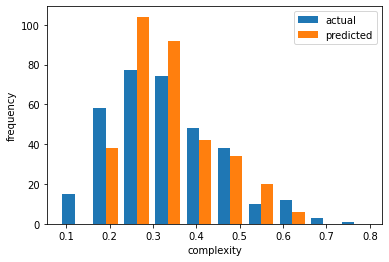

In [62]:
plt.hist([lcp_single_dev[multisyllabic].complexity, lcp_single_dev[multisyllabic].complexity_pred], label=['actual', 'predicted'])
plt.xlabel('complexity')
plt.ylabel('frequency')
plt.legend(loc='upper right')

In [80]:
multisyllabic_50_idx = lcp_single_dev_ordered.head(50)['token'].apply(lambda x: syllables.estimate(str(x))) >= 3
multisyllabic_100_idx = lcp_single_dev_ordered.head(100)['token'].apply(lambda x: syllables.estimate(str(x))) >= 3

In [81]:
multisyllabic.sum() - multisyllabic_50_idx.sum()

314

In [82]:
multisyllabic.sum() - multisyllabic_100_idx.sum()

294

In [83]:
multisyllabic.sum()

336

(1st attempt, probably wrong) Evaluating Weicheng's hypothesis that the harder an aspect words is, the less likely the word can be inferred from its context (with the aspect words masked out).

In [89]:
lcp_single_dev['error'] = np.abs(lcp_single_dev['complexity'] - lcp_single_dev['complexity_pred'])

In [90]:
lcp_single_dev[['complexity', 'error']].corr()

complexity     error
complexity    1.000000  0.152598
error         0.152598  1.000000

In [151]:
lcp_single_dev.head()

id corpus  \
403   3NSM4HLQNRUPDSMYRR2BPK23K4CQQD  bible   
849   3QX22DUVOOHQXLKNLXP4EYH6RVOMVA  bible   
1052  3IKMEYR0LWVMA6MICBSDXGSR5S0K2V  bible   
886   3UYRNV2KITZY4R9AP5TUZZMYLNY8NS  bible   
892   3B9J25CZ25DXW7RSEDQL0FSNYBQSCP  bible   

                                               sentence      token  \
403   Behold, a wall on the outside of the house all...  thickness   
849   In the evening she went, and on the next day s...    custody   
1052  But bring those enemies of mine who didn't wan...       mine   
886   For they were in three stories, and they didn'...     courts   
892   If the man said to him, "Let the fat be burned...    desires   

      complexity class  complexity_pred     error  
403     0.125000     1         0.281372  0.156372  
849     0.175000     1         0.273276  0.098276  
1052    0.197368     1         0.239647  0.042279  
886     0.178571     1         0.287084  0.108513  
892     0.178571     1         0.239878  0.061307

Are short abbreviations tokenized into multiple BPEs usually predicted lower than the gold standard?

In [221]:
lcp_single_dev_ordered['tokenized_aspect_word'] = for_weicheng['tokenized_aspect_word']
lcp_single_dev_ordered['num_BPEs'] = lcp_single_dev_ordered['tokenized_aspect_word'].apply(lambda x: len(x.split(' ')))
lcp_single_dev_ordered['error'] = np.abs(lcp_single_dev_ordered['complexity']-lcp_single_dev_ordered['complexity_pred'])

In [222]:
lcp_single_dev_ordered.head()

id  corpus  \
2568  3VAOOVPI3ZS3VYQ87HMJRC4F0QPLLD   bible   
2573  3O2Y2UIUCQU6B0YU067KHZMGEWBKFL   bible   
5149  3UEBBGULPFOKEW36UKBMNMVEGNSUFB  biomed   
5134  38B7Q9C28G5QBBMSVGDRXKVNA3B69P  biomed   
1319  3W1K7D6QSBHBNEL0V5OYLOJ837WZB4   bible   

                                               sentence      token  \
2568  and the pelican, and the vulture, and the corm...  cormorant   
2573  he sent Hadoram his son to king David, to Gree...        Tou   
5149    Supplementary data are available at NAR online.        NAR   
5134  In various manipulations of the neurotrophins ...        KOs   
1319  and the border shall go down to the Jordan, an...     goings   

      complexity class  complexity_pred            tokenized_aspect_word  \
2568    0.652778     4         0.337292  ['co', '##rm', '##oran', '##t']   
2573    0.825000     5         0.526320                    ['To', '##u']   
5149    0.861111     5         0.603327                    ['N', '##AR']   
5134    0.775000     4         0.527917                    ['K', '##Os']   
1319    0.225000     2         0.459518                 ['going', '##s']   

      num_BPEs     error  
2568         4  0.315486  
2573         2  0.298680  
5149         2  0.257784  
5134         2  0.247083  
1319         2  0.234518

In [192]:
multiple_BPEs = lcp_single_dev_ordered['num_BPEs'] > 1

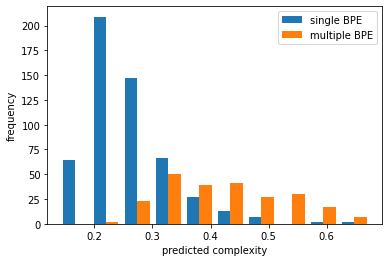

In [217]:
plt.hist([lcp_single_dev_ordered.loc[~multiple_BPEs]['complexity_pred'], lcp_single_dev_ordered.loc[multiple_BPEs]['complexity_pred']], label=['single BPE', 'multiple BPE'])
plt.xlabel('predicted complexity')
plt.ylabel('frequency')
plt.legend(loc='upper right')

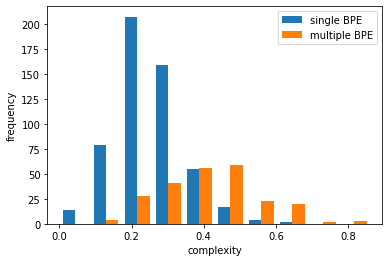

In [213]:
plt.hist([lcp_single_dev_ordered.loc[~multiple_BPEs]['complexity'], lcp_single_dev_ordered.loc[multiple_BPEs]['complexity']], label=['single BPE', 'multiple BPE'])
plt.xlabel('complexity')
plt.ylabel('frequency')
plt.legend(loc='upper right')

- Checking how much the sentence embeddings change with and without the aspect words masked.
- (2nd attempt) Evaluating Weicheng's hypothesis that the harder an aspect words is, the less likely the word can be inferred from its context (with the aspect words masked out).
    - Seems to be true.
- Follow-up: Is it true that in complex cases, predicted scores are usually lower than they should be, and masking out aspect words further lowers the scores?

In [464]:
path = './data/from_discovery_or_colab/cased_lcp_dev_scores_tokens_unmasked.json'
results = json.load(open(path))
single_dev_y_pred = np.array(results['scores'])
print(mean_absolute_error(single_dev_y, single_dev_y_pred), pearsonr(single_dev_y, single_dev_y_pred)[0], spearmanr(single_dev_y, single_dev_y_pred)[0])

0.06349116677984828 0.7923266311829003 0.7459651107675874


In [408]:
lcp_single_dev['complexity_pred_unmasked'] = single_dev_y_pred
lcp_single_dev['abs_error_token_unmasked'] = np.abs(single_dev_y-single_dev_y_pred)
lcp_single_dev['error_token_unmasked'] = single_dev_y_pred-single_dev_y

In [409]:
path = './data/from_discovery_or_colab/cased_lcp_dev_scores_tokens_masked.json'
results = json.load(open(path))
single_dev_y_pred = np.array(results['scores'])
print(mean_absolute_error(single_dev_y, single_dev_y_pred), pearsonr(single_dev_y, single_dev_y_pred)[0], spearmanr(single_dev_y, single_dev_y_pred)[0])

0.07306958875645699


In [410]:
lcp_single_dev['complexity_pred_masked'] = single_dev_y_pred
lcp_single_dev['abs_error_token_masked'] = np.abs(single_dev_y-single_dev_y_pred)
lcp_single_dev['error_token_masked'] = single_dev_y_pred-single_dev_y

In [411]:
lcp_single_dev.head()

id corpus  \
403   3NSM4HLQNRUPDSMYRR2BPK23K4CQQD  bible   
849   3QX22DUVOOHQXLKNLXP4EYH6RVOMVA  bible   
1052  3IKMEYR0LWVMA6MICBSDXGSR5S0K2V  bible   
886   3UYRNV2KITZY4R9AP5TUZZMYLNY8NS  bible   
892   3B9J25CZ25DXW7RSEDQL0FSNYBQSCP  bible   

                                               sentence      token  \
403   Behold, a wall on the outside of the house all...  thickness   
849   In the evening she went, and on the next day s...    custody   
1052  But bring those enemies of mine who didn't wan...       mine   
886   For they were in three stories, and they didn'...     courts   
892   If the man said to him, "Let the fat be burned...    desires   

      complexity class  complexity_pred_unmasked  abs_error_token_unmasked  \
403     0.125000     1                  0.273393                  0.148393   
849     0.175000     1                  0.262161                  0.087161   
1052    0.197368     1                  0.237702                  0.040334   
886     0.178571     1                  0.294603                  0.116032   
892     0.178571     1                  0.232837                  0.054265   

      error_token_unmasked  complexity_pred_masked  abs_error_token_masked  \
403               0.148393                0.250932                0.125932   
849               0.087161                0.236992                0.061992   
1052              0.040334                0.226628                0.029260   
886               0.116032                0.263531                0.084960   
892               0.054265                0.215169                0.036598   

      error_token_masked  complexity_pred_unmasked_incremented  \
403             0.125932                              0.273393   
849             0.061992                              0.262161   
1052            0.029260                              0.237702   
886             0.084960                              0.294603   
892             0.036598                              0.232837   

      error_token_unmasked_incremented  
403                           0.148393  
849                           0.087161  
1052                          0.040334  
886                           0.116032  
892                           0.054265

In [412]:
lcp_single_dev[['complexity', 'abs_error_token_unmasked']].corr()

complexity  abs_error_token_unmasked
complexity                  1.000000                  0.258512
abs_error_token_unmasked    0.258512                  1.000000

In [413]:
lcp_single_dev[['complexity', 'abs_error_token_masked']].corr()

complexity  abs_error_token_masked
complexity                1.000000                0.588711
abs_error_token_masked    0.588711                1.000000

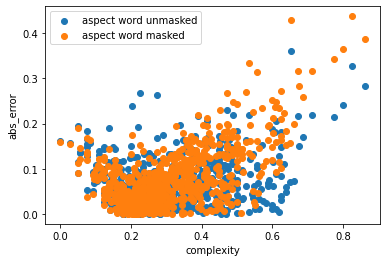

In [414]:
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['abs_error_token_unmasked'], label='aspect word unmasked')
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['abs_error_token_masked'], label='aspect word masked')
plt.xlabel('complexity')
plt.ylabel('abs_error')
plt.legend(loc='upper left')
plt.show()

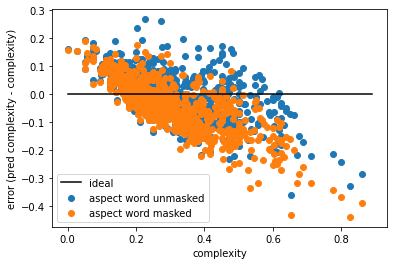

In [454]:
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['error_token_unmasked'], label='aspect word unmasked')
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['error_token_masked'], label='aspect word masked')
plt.plot(np.arange(0, 0.9, 0.01), [0]*90, color='black', label='ideal')
plt.xlabel('complexity')
plt.ylabel('error (pred complexity - complexity)')
plt.legend(loc='lower left')
plt.show()

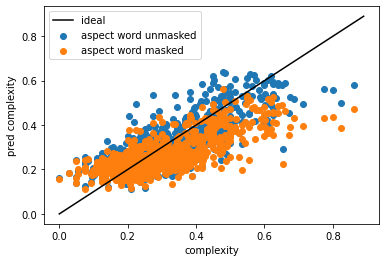

In [449]:
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['complexity_pred_unmasked'], label='aspect word unmasked')
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['complexity_pred_masked'], label='aspect word masked')
plt.plot(np.arange(0, 0.9, 0.01), np.arange(0, 0.9, 0.01), color='black', label='ideal')
plt.xlabel('complexity')
plt.ylabel('pred complexity')
plt.legend(loc='upper left')
plt.show()

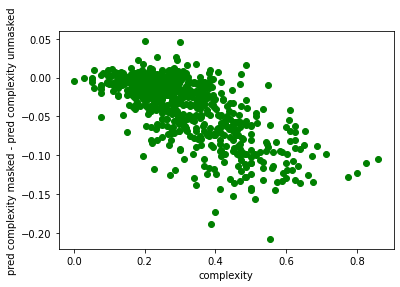

In [457]:
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['complexity_pred_masked']-lcp_single_dev['complexity_pred_unmasked'], color='green')
plt.xlabel('complexity')
plt.ylabel('pred complexity masked - pred complexity unmasked')
plt.show()

In [465]:
increment, threshold = 0.11, 0.19
lcp_single_dev['complexity_pred_unmasked_incremented'] = lcp_single_dev['complexity_pred_unmasked'] 
lcp_single_dev['complexity_pred_unmasked_incremented'][lcp_single_dev['complexity_pred_unmasked'] - lcp_single_dev['complexity_pred_masked'] > threshold] += increment
single_dev_y_pred = lcp_single_dev['complexity_pred_unmasked_incremented']
print(mean_absolute_error(single_dev_y, single_dev_y_pred), pearsonr(single_dev_y, single_dev_y_pred)[0], spearmanr(single_dev_y, single_dev_y_pred)[0])

0.06335562794958531 0.7929201518013036 0.7460584308965663


In [ ]:
0.06349116677984828 0.7923266311829003 0.7459651107675874

In [438]:
lcp_single_dev['error_token_unmasked_incremented'] = lcp_single_dev['complexity_pred_unmasked_incremented'] - single_dev_y

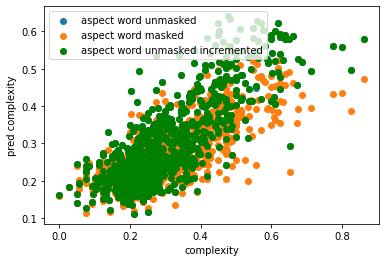

In [439]:
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['complexity_pred_unmasked'], label='aspect word unmasked')
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['complexity_pred_masked'], label='aspect word masked')
plt.scatter(lcp_single_dev['complexity'],lcp_single_dev['complexity_pred_unmasked_incremented'], label='aspect word unmasked incremented', color='green')
plt.xlabel('complexity')
plt.ylabel('pred complexity')
plt.legend(loc='upper left')
plt.show()

In [475]:
d = 0.01
best_m = best_i = best_t = None
for i in np.arange(0, 0.5+d, d):
    for t in np.arange(0, 0.5+d, d):
        lcp_single_dev['complexity_pred_unmasked_incremented'] = lcp_single_dev['complexity_pred_unmasked']
        lcp_single_dev['complexity_pred_unmasked_incremented'][np.abs(lcp_single_dev['complexity_pred_unmasked'] - lcp_single_dev['complexity_pred_masked']) > t] += i
        single_dev_y_pred = lcp_single_dev['complexity_pred_unmasked_incremented']
        m = mean_absolute_error(single_dev_y, single_dev_y_pred)
        if not best_m or m < best_m:
            best_m, best_i, best_t = m, i, t
best_m, best_i, best_t

(0.06335562794958531, 0.11, 0.19)

Experiments comparing the model performances on the same instances when fine-tuned on the dataset with aspect words masked and unmasked, respectively. I did this on Colab.

Since the labels are super imbalanced, try re-scaling them.

In [483]:
lcp_single_train['class'].value_counts()

2    3964
1    1544
3    1162
4     205
5      10
Name: class, dtype: int64

In [537]:
single_train_complexity = lcp_single_train['complexity'].to_numpy().reshape(-1, 1)
single_dev_complexity = lcp_single_dev['complexity'].to_numpy().reshape(-1, 1)
single_trial_complexity = lcp_single_trial['complexity'].to_numpy().reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(single_train_complexity) 

StandardScaler()

In [538]:
scaler.mean_, scaler.var_**0.5

(array([0.30221784]), array([0.13310276]))

In [540]:
lcp_single_train['complexity_scaled'] = scaler.transform(single_train_complexity).ravel()
lcp_single_dev['complexity_scaled'] = scaler.transform(single_dev_complexity).ravel()
lcp_single_trial['complexity_scaled'] = scaler.transform(single_trial_complexity).ravel()

In [544]:
lcp_single_train.head()

id corpus  \
218  3UUSLRKAUL3LI1DEQ6NLPUE9WZQD7S  bible   
877  3VDI8GSXAFTSUZSO21GZ9FD1KBC8GK  bible   
415  344M16OZKIFFDSJ128FUR9IKWQ1EN2  bible   
309  39XCQ6V3KY47AOKGSQ0AL4QLO7856D  bible   
502  3S8APUMBJXJ5IXU0UTURIW3QR0XFBN  bible   

                                              sentence      token  complexity  \
218  Haman recounted to them the glory of his riche...   servants    0.176471   
877  As they were making their hearts merry, behold...     hearts    0.191176   
415     How much better it is to get wisdom than gold!     wisdom    0.142857   
309  The sun will be darkened in its going forth, a...      light    0.181818   
502  being approved by good works, if she has broug...  strangers    0.132353   

    class  complexity_scaled  
218     1          -0.944738  
877     1          -0.834253  
415     1          -1.197276  
309     1          -0.904562  
502     1          -1.276194

In [508]:
bins = np.array([
    [0.0, 0.2],
    [0.2, 0.4],
    [0.4, 0.6],
    [0.6, 0.8],
    [0.8, 1.0]
])

In [512]:
bins_scaled = (bins - scaler.mean_)/(scaler.var_**0.5)
bins_scaled

array([[-2.27056035, -0.76796188],
       [-0.76796188,  0.73463659],
       [ 0.73463659,  2.23723507],
       [ 2.23723507,  3.73983354],
       [ 3.73983354,  5.24243201]])

Hypernyms

In [69]:
lcp_single_train = pkl.load(open('./data/lcp_single_train.pkl', 'rb'))

In [70]:
sentence = 'He said to them, "Which of you, if you go to a friend at midnight, and tell him, \'Friend, lend me three loaves of bread,'

In [71]:
def get_token_POS(row):
    word_tokens = word_tokenize(row['sentence'])
    if row['token'] in word_tokens:
        pos_tags = dict(pos_tag(word_tokens))
        return pos_tags[row['token']]
    else:
        print(row['token'])
        return np.nan

In [72]:
lcp_single_train['token_POS'] = lcp_single_train.apply(lambda x: get_token_POS(x), axis=1)

Friend
checkpoints
machine
transporter
abnormalities
length
K
cre
inter
K
K
K
K
cre
SDS
N
N
SDS
state
Criminal
Barcelona
Allegation
instigators


In [197]:
lcp_single_train.head()

id corpus  \
218  3UUSLRKAUL3LI1DEQ6NLPUE9WZQD7S  bible   
877  3VDI8GSXAFTSUZSO21GZ9FD1KBC8GK  bible   
415  344M16OZKIFFDSJ128FUR9IKWQ1EN2  bible   
309  39XCQ6V3KY47AOKGSQ0AL4QLO7856D  bible   
502  3S8APUMBJXJ5IXU0UTURIW3QR0XFBN  bible   

                                              sentence      token  complexity  \
218  Haman recounted to them the glory of his riche...   servants    0.176471   
877  As they were making their hearts merry, behold...     hearts    0.191176   
415     How much better it is to get wisdom than gold!     wisdom    0.142857   
309  The sun will be darkened in its going forth, a...      light    0.181818   
502  being approved by good works, if she has broug...  strangers    0.132353   

    class token_POS  
218     1       NNS  
877     1       NNS  
415     1        NN  
309     1        NN  
502     1       NNS

In [203]:
lcp_single_train['token_POS'].value_counts()

NN      3568
NNS     1730
NNP     1205
JJ       152
VBG       44
VB        41
NNPS      38
VBZ       29
VBP       15
VBN        8
RB         7
IN         5
DT         4
CC         3
JJR        2
FW         2
VBD        2
JJS        2
WP         1
PDT        1
RP         1
WRB        1
CD         1
Name: token_POS, dtype: int64

In [206]:
lcp_single_train[lcp_single_train['token_POS'].isin(['IN','DT','CC','JJR','FW','VBD','JJS','WP','PDT','RP','WRB','CD'])]

id    corpus  \
690   3QREJ3J433XSBS8QMHAICCR0BSSLKM     bible   
2117  3SNR5F7R92TNZR8A5S22M1M3AR2IEL     bible   
2017  3D3B8GE892RYLH4XACC03KM458H9PE     bible   
2254  3LN3BXKGC0V3K0O604W5NVGN2IKGWC     bible   
1923  38VTL6WC4AD9T8UMY9V24VAENFB5YJ     bible   
492   3SBNLSTU6U542BJK91F4GE786S2ZD5     bible   
768   3Y40HMYLL1I1EIURUEH8TTVLKQZUX9     bible   
1987  3HUR21WDDUPIVREW4FEXWE1YGE3YX4     bible   
2084  3TKXBROM5TAVA7U2JTDTJHZVFXQJIV     bible   
1713  37G6BXQPLQL0GPWTI07BV3DP11JQEW     bible   
2392  3R868ACW4SC7EVTBBRGCMZA5JKIZGF     bible   
1989  3SU800BH86SH5LTF80MGZLZSNN0UQ0     bible   
3512  3RHLQY6EDT4OZEVVO8PEMIUZ5XJ4DI    biomed   
3338  309D674SHZLYFLAQ3R4QAQINUPUCB2    biomed   
4657  37SDSEDIN92VQK2LKIVW2S9VIMI182    biomed   
3514  3LB1BGHFL2WBEA5CZ5D07BGS3L4YTG    biomed   
3623  38EHZ67RIMS7FOUSW2QIEXEW4GKGMZ    biomed   
4159  3MYASTQBG7BVOJITM5WRPLV41QZQDM    biomed   
4494  35JDMRECC499302FF42Z1P9NVFRGEA    biomed   
5005  38O9DZ0A62NFBR1TA7YCNXN94YY26S    biomed   
5128  306W7JMRYYYW3IKDMFOL84M44Y3B8P    biomed   
5115  39KV3A5D187RKQWWNWIAKT09X2OS7P    biomed   
6365  3CZH926SICETRK9VK30YS0CK5AM4EF  europarl   
5746  337F8MIIMZDU0UU1CW1J7BAGBAV40E  europarl   
7572  3WA2XVDZEMH767D93RTDPYWY128E6S  europarl   

                                               sentence        token  \
690   Whenever any controversy shall come to you fro...     Whenever   
2117                        "Asher's food will be rich.        Asher   
2017  "Woe to you, you blind guides, who say, 'Whoev...          Woe   
2254  Yet all this avails me nothing, so long as I s...     Mordecai   
1923  Jehoshaphat slept with his fathers, and was bu...  Jehoshaphat   
492   When they cried out to Yahweh, he put darkness...     darkness   
768   The remnant of the trees of his forest shall b...       forest   
1987  When I made sackcloth my clothing, I became a ...    sackcloth   
2084  spikenard and saffron, calamus and cinnamon, w...        myrrh   
1713  Annas the high priest was there, with Caiaphas...        Annas   
2392  Ahi the son of Abdiel, the son of Guni, chief ...          Ahi   
1989  Please let us put sackcloth on our bodies, and...    sackcloth   
3512  Several studies of this CSS panel, B6 Chr1-19,...       weight   
3338  We note that several apparently highly express...         zone   
4657  APC also interacts with a multitude of other c...        discs   
3514  RMCE with a p53ΔPGFP replacement plasmid was a...       weight   
3623  Secondly we investigated reporter co-visualiza...     reporter   
4159  Knockout of the X-linked Avpr2 gene in mice [1...     Knockout   
4494  Changes in neuron excitability in the hippocam...       neuron   
5005  Myosin Va is enriched in the PSD [43], and DNC...        oxide   
5128  In Alk5 mutants there is very little, if any, ...          OFT   
5115  Locus 7 on chromosome 16 overlaps with Lp1, wh...   lymphocyte   
6365  (NL) Madam President, I have voted against the...      witness   
5746  Whether it is an individual delivering meals o...       forest   
7572  The next item is the report by Mrs del Castill...          del   

      complexity class token_POS  
690     0.152778     1       WRB  
2117    0.367647     2        DT  
2017    0.355263     2        WP  
2254    0.400000     2       PDT  
1923    0.319444     2        DT  
492     0.302632     2        RP  
768     0.218750     2       JJS  
1987    0.500000     3        CC  
2084    0.447368     3        CC  
1713    0.426471     3        IN  
2392    0.455882     3        IN  
1989    0.510870     3        DT  
3512    0.187500     1       VBD  
3338    0.235294     2        CD  
4657    0.397727     2        FW  
3514    0.205882     2       VBD  
3623    0.277778     2       JJR  
4159    0.277778     2        IN  
4494    0.411765     3        DT  
5005    0.546875     3        IN  
5128    0.675000     4        CC  
5115    0.640625     4       JJR  
6365    0.273810     2        IN  
5746    0.235294    

In [415]:
def get_POS(sentence, token, debug=False):
    word_tokens = word_tokenize(sentence)
    pos_tags = pos_tag(word_tokens)
    if token in word_tokens:
        idx = word_tokens.index(token)
    else:
        if debug:
            return np.nan
        for word_token in word_tokens:
            if token in word_token:
                break
        else:
            return np.nan
        return get_POS(sentence.replace(word_token, token), token, debug=True)
    return pos_tags[idx][1]

In [416]:
lcp_single_train['POS'] = lcp_single_train.apply(lambda x: get_POS(x['sentence'], x['token']), axis=1)

In [418]:
lcp_single_train['POS'].value_counts()

NN      3574
NNS     1731
NNP     1219
JJ       152
VBG       44
VB        41
NNPS      38
VBZ       29
VBP       15
VBN        8
RB         7
IN         5
DT         4
VBD        3
CC         3
FW         2
JJR        2
JJS        2
RP         1
PDT        1
WP         1
WRB        1
CD         1
Name: POS, dtype: int64

In [432]:
result = pd.get_dummies(lcp_single_train['POS'], prefix='POS')
result['complexity'] = lcp_single_train['complexity']
result.corr()['complexity'].abs().sort_values(ascending=False)

complexity    1.000000
POS_NNP       0.243416
POS_NN        0.125798
POS_NNS       0.093842
POS_JJ        0.044634
POS_CC        0.037423
POS_VB        0.027136
POS_JJR       0.020104
POS_IN        0.019027
POS_DT        0.018153
POS_FW        0.017637
POS_VBN       0.014410
POS_NNPS      0.014066
POS_WRB       0.013532
POS_VBP       0.011820
POS_RB        0.011400
POS_VBD       0.010280
POS_JJS       0.009630
POS_PDT       0.008854
POS_VBG       0.008445
POS_VBZ       0.007175
POS_CD        0.006060
POS_WP        0.004803
POS_RP        0.000037
Name: complexity, dtype: float64

In [400]:
lcp_single_train.loc[3190]

id                                       33K3E8REWWV3GLNERBG3X1DWN1W8X0
corpus                                                           biomed
sentence              To avoid such deleterious outcomes, surveillan...
token                                                     abnormalities
complexity                                                     0.232143
class                                                                 2
tfidf                                                                 0
parse_tree_depth                                                    NaN
token_depth                                                         NaN
num_words_at_depth                                                  NaN
Name: 3190, dtype: object

In [373]:
lcp_single_train.loc[3190].sentence

'To avoid such deleterious outcomes, surveillance systems (‚“checkpoints‚”) exist to sense meiotic errors and eliminate cells containing unresolved defects.'

In [468]:
def get_hyponyms(word):
    hyponyms = []
    for ss in wn.synsets(word):
        for hyper in ss.hyponyms():
            hyponyms.append(hypo.name())
    return hyponyms
def get_hypernyms(word):
    hypernyms = []
    for ss in wn.synsets(word):
        for hyper in ss.hypernyms():
            hypernyms.append(hyper.name())
    return hypernyms

In [74]:
get_hypernyms('light')

['actinic_radiation.n.01',
 'source_of_illumination.n.01',
 'position.n.03',
 'physical_property.n.01',
 'scene.n.01',
 'condition.n.01',
 'visual_property.n.01',
 'friend.n.01',
 'illumination.n.02',
 'insight.n.03',
 'expression.n.01',
 'vitality.n.01',
 'public_knowledge.n.01',
 'ethical_motive.n.01',
 'visual_signal.n.01',
 'device.n.01',
 'lighten.v.05',
 'ignite.v.01',
 'land.v.01',
 'burn.v.05',
 'fall.v.21',
 'descend.v.01']

In [233]:
lcp_single_train.head()

id corpus  \
218  3UUSLRKAUL3LI1DEQ6NLPUE9WZQD7S  bible   
877  3VDI8GSXAFTSUZSO21GZ9FD1KBC8GK  bible   
415  344M16OZKIFFDSJ128FUR9IKWQ1EN2  bible   
309  39XCQ6V3KY47AOKGSQ0AL4QLO7856D  bible   
502  3S8APUMBJXJ5IXU0UTURIW3QR0XFBN  bible   

                                              sentence      token  complexity  \
218  Haman recounted to them the glory of his riche...   servants    0.176471   
877  As they were making their hearts merry, behold...     hearts    0.191176   
415     How much better it is to get wisdom than gold!     wisdom    0.142857   
309  The sun will be darkened in its going forth, a...      light    0.181818   
502  being approved by good works, if she has broug...  strangers    0.132353   

    class token_POS  num_hypernyms  
218     1       NNS              2  
877     1       NNS             11  
415     1        NN              4  
309     1        NN             22  
502     1       NNS              2

In [75]:
lcp_single_train['num_hypernyms'] = lcp_single_train['token'].apply(lambda x: len(get_hypernyms(x)))

In [76]:
lcp_single_train[['complexity', 'num_hypernyms']].corr()

complexity  num_hypernyms
complexity       1.000000      -0.328996
num_hypernyms   -0.328996       1.000000

Text(0, 0.5, 'complexity')

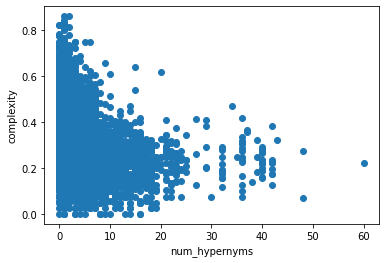

In [229]:
plt.scatter(lcp_single_train['num_hypernyms'], lcp_single_train['complexity'])
plt.xlabel('num_hypernyms')
plt.ylabel('complexity')

Text(0, 0.5, 'frequency')

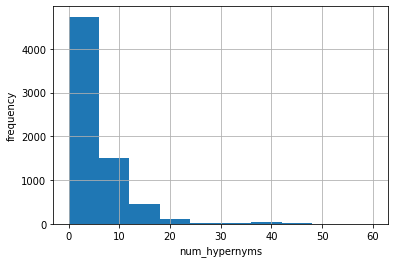

In [230]:
lcp_single_train['num_hypernyms'].hist()
plt.xlabel('num_hypernyms')
plt.ylabel('frequency')

In [78]:
lcp_single_train['num_synsets'] = lcp_single_train['token'].apply(lambda x: len(wn.synsets(x)))

In [79]:
lcp_single_train[['complexity', 'num_synsets']].corr()

complexity  num_synsets
complexity     1.000000    -0.328214
num_synsets   -0.328214     1.000000

Text(0, 0.5, 'complexity')

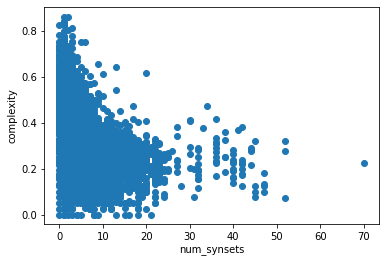

In [80]:
plt.scatter(lcp_single_train['num_synsets'], lcp_single_train['complexity'])
plt.xlabel('num_synsets')
plt.ylabel('complexity')

Oops, instead of hypernyms right away, first disambiguating the senses of words in the context.

In [82]:
lcp_single_train.iloc[3].sentence

'The sun will be darkened in its going forth, and the moon will not cause its light to shine.'

In [85]:
sentence = 'The sun will be darkened in its going forth, and the moon will not cause its light to shine.'
disambiguation = lesk(sentence, 'sun')
disambiguation.definition()

'first day of the week; observed as a day of rest and worship by most Christians'

In [293]:
word_tokenize(sentence)

['The',
 'sun',
 'will',
 'be',
 'darkened',
 'in',
 'its',
 'going',
 'forth',
 ',',
 'and',
 'the',
 'moon',
 'will',
 'not',
 'cause',
 'its',
 'light',
 'to',
 'shine',
 '.']

In [414]:
def get_hyponyms(sentence, word, disambiguate=True):
    if disambiguate:
        l = lesk(sentence, word)
        if not l:
            return []
        return [hyponym.name() for hyponym in l.hyponyms()]
    else:
        hyponyms = []
        for ss in wn.synsets(word):
            for hyponym in ss.hyponyms():
                hyponyms.append(hyponym.name())
        return hyponyms
def get_hypernyms(sentence, word, disambiguate=True):
    if disambiguate:
        l = lesk(sentence, word)
        if not l:
            return []
        return [hypernym.name() for hypernym in l.hypernyms()]
    else:
        hypernyms = []
        for ss in wn.synsets(word):
            for hypernym in ss.hypernyms():
                hypernyms.append(hypernym.name())
        return hypernyms

In [161]:
get_hypernyms('The man walks his dog', 'man')

['body_servant.n.01', 'manservant.n.01']

In [311]:
nones = []
for i, row in lcp_single_train.iterrows():
    sentence = row['sentence']
    word = row['token']
    l = lesk(word_tokenize(sentence), word)
    if not l:
        nones.append(i)
        continue
    result = [hyper.name() for hyper in l.hypernyms()]

In [312]:
lcp_single_train.loc[nones, :]

id    corpus  \
25    3DFYDSXB2W00JYP2DA272KN69UQJUK     bible   
24    3UEBBGULPFOKEW36UKBMNMVEGN9UFS     bible   
215   3KI0JD2ZU1IMXSYZGJF7JO4HFBR76E     bible   
690   3QREJ3J433XSBS8QMHAICCR0BSSLKM     bible   
422   37M4O367VJI9ZR58F67RA0N7E5X5MT     bible   
...                              ...       ...   
7315  3R15W654VDTEMV6LZMUF8Y39A0LLQJ  europarl   
7549  3ICOHX7ENCBCSWRU12DWGXM7OY60EV  europarl   
7649  3JTPR5MTZSCE9355UUUBVNV3P3CK5J  europarl   
7648  385MDVINFCFDB2E78AH8K883UBGWJD  europarl   
7660  3THR0FZ95PTB1JT5K92BJT89VYNOLW  europarl   

                                               sentence       token  \
25    For everyone who exalts himself will be humble...    everyone   
24                   Happy is everyone who retains her.    everyone   
215   Yahweh said in his heart, "I will not again cu...  everything   
690   Whenever any controversy shall come to you fro...    Whenever   
422   Samuel said to Jesse, "Are all your children h...       Jesse   
...                                                 ...         ...   
7315  The next item is the debate on six motions for...      Cesare   
7549  The next item is the report (A5-0154/2002) by ...    Petersen   
7649  The next item is the report by Giuseppe Gargan...    Giuseppe   
7648  The next item is the debate on the oral questi...          EP   
7660  There is apparently here in this Parliament a ...        Quod   

      complexity class token_POS  num_hypernyms  
25      0.166667     1        NN              0  
24      0.000000     1        NN              0  
215     0.166667     1        NN              0  
690     0.152778     1       WRB              0  
422     0.125000     1       NNP              0  
...          ...   ...       ...            ...  
7315    0.550000     3       NNP              0  
7549    0.466667     3       NNP              0  
7649    0.615385     4       NNP              0  
7648    0.611111     4       NNP              0  
7660    0.678571     4       NNP              0  

[193 rows x 8 columns]

In [313]:
lcp_single_train['num_hypernyms'] = lcp_single_train.apply(lambda x: len(get_hypernyms(x['sentence'], x['token'])), axis=1)

In [314]:
lcp_single_train[['complexity', 'num_hypernyms']].corr()

complexity  num_hypernyms
complexity       1.000000      -0.162185
num_hypernyms   -0.162185       1.000000

Text(0, 0.5, 'complexity')

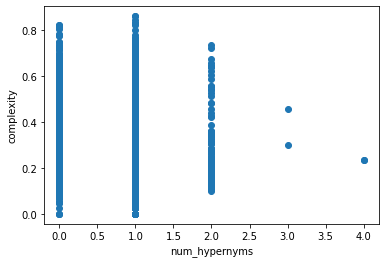

In [315]:
plt.scatter(lcp_single_train['num_hypernyms'], lcp_single_train['complexity'])
plt.xlabel('num_hypernyms')
plt.ylabel('complexity')

Text(0, 0.5, 'frequency')

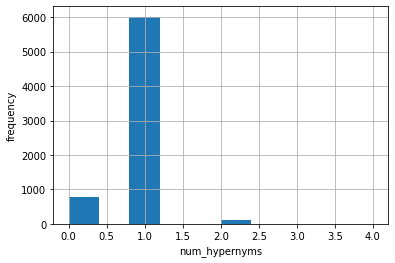

In [317]:
lcp_single_train['num_hypernyms'].hist()
plt.xlabel('num_hypernyms')
plt.ylabel('frequency')

Next let’s formulate each instance like [CLS]sentence[SEP] without appending the aspect words at the end.
After getting the evaluation results, looking at the pooled attention map generated by BERT model at the top layer, as well as the gradient distribution on every word (also on top layer)

In [5]:
path = './data/from_discovery_or_colab/cased_lcp_dev_scores_no_token.json'
results = json.load(open(path))
single_dev_y = lcp_single_dev['complexity'].to_numpy()
single_dev_y_pred = np.array(results['scores'])
print(mean_absolute_error(single_dev_y, single_dev_y_pred), pearsonr(single_dev_y, single_dev_y_pred)[0], spearmanr(single_dev_y, single_dev_y_pred)[0])

0.09601116350405231 0.34074748727123483 0.32271844080226353


In [6]:
lcp_single_dev['complexity_pred'] = single_dev_y_pred
lcp_single_dev['abs_error'] = np.abs(single_dev_y_pred-single_dev_y)
lcp_single_dev.insert(1, 'idx', range(len(lcp_single_dev)))
lcp_single_dev_ordered = lcp_single_dev.sort_values('abs_error', ascending=True)

In [8]:
pd.set_option('display.max_colwidth', -1)

In [10]:
lcp_single_dev_ordered[['idx', 'sentence', 'token', 'complexity']].head(31)

idx  \
5418  584   
1333  132   
2816  394   
6304  654   
6262  612   
3434  355   
6778  694   
1635  95    
3883  379   
5619  702   
1440  183   
1886  181   
6537  611   
2833  410   
4098  357   
4375  435   
1195  91    
5783  716   
966   147   
5889  624   
6254  709   
6589  727   
5503  630   
1729  89    
6158  713   
1627  190   
1314  79    
2015  108   
6053  657   
4276  370   
6457  705   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sentence  \
5418  The next item is the Council and Commission statements on the 2010 progress report on Iceland.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1333  until I make your enemies a footstool for your feet."'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2816  Therefore, we have presented a strategy to identify small-effect QTL and search for potential candidate genes within them.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
6304  This is when the Treaty establishing the European Coal and Steel Community (ECSC) expired after 50 years and a successor arrangement was needed, not only with regard to aid, but also other issues.                                                                                                                                                                                                                                                                                                                                                                                                                                                   
6262  We would also like to ask the Commission, represented here today, to propose a rapid, considerable increase in European Union financial resources for Somalia, particularly on the occasion of the intermediate review of the 10th European Development Fund, and also an increase in its physical presence in that country.                                                                             

In [32]:
lcp_single_dev_ordered[['class', 'abs_error']].groupby('class').mean()

abs_error
class           
1       0.107228
2       0.047823
3       0.189101
4       0.346436
5       0.547589

Correlation between sentence-level readibilty and complexity?
- Interesting. I thought the correlation scores would be higher.

In [31]:
funcs = ["textstat." + inspect.getmembers(textstat, predicate=inspect.ismethod)[i][0] for i in range(1,28)]

In [ ]:
del lcp_single_train['readability']

for elem in funcs:
    method = eval(elem)
    if method.__name__ in ['difficult_words_list', 'set_lang', 'text_standard']:
        continue
    textstat.set_lang("en")
    lcp_single_train['readability'] = lcp_single_train['sentence'].apply(lambda x: method(x))
    print(elem.split(".")[1])
    print(lcp_single_train[['complexity','readability']].corr().iloc[0,1])
    del lcp_single_train['readability']

Let's try GPT-2 perplexity scores, instead of readability. I did this on colab.
- 0.002319, ie. little to no correlation.

Let's also try aspect word TF-IDF scores.

In [135]:
def ChunkIterator(documents):
  for document in documents:
    yield document
def get_tfidf(documents, lowercase=True, token_pattern=r'(?u)\b\w+\b', ngram_range=(1,1)):
    v = TfidfVectorizer(lowercase=lowercase, token_pattern=token_pattern, ngram_range=ngram_range)
    v.fit(ChunkIterator(documents))
    return v

In [142]:
path = 'data/bible-corpus-tools/TXT_Bibles/English-WEB.txt'
with open(path) as file:
    external_sentences = [line.strip() for line in file.readlines()]

In [145]:
import xml.etree.ElementTree as ET
path = 'data/bible-corpus-tools/XML_Bibles/'
lang = 'English'
root = ET.fromstring(open(path + lang + '.xml').read())


In [147]:
book_id = 'b.GEN'
for n in root.findall('.//div[@id="'+book_id+'"]/*seg'):
    #out.write(n.text.strip() + '\n')
    print(n.text)
    break
#with open(lang + '-' + book_id + '.txt', 'w', encoding='utf-8') as out:


						In the beginning God created the heaven and the earth.
					


In [93]:
v = get_tfidf(external_sentences, False)
lcp_single_train_bible = lcp_single_train[lcp_single_train['corpus']=='bible']
result = v.transform(lcp_single_train_bible['sentence'])
lcp_single_train_bible['idx'] = range(len(lcp_single_train_bible))
lcp_single_train_bible['tfidf'] = lcp_single_train_bible.apply(lambda x: result[x['idx'], v.vocabulary_[x['token'].lower() if v.__dict__['lowercase'] else x['token']]], axis=1)
lcp_single_train_bible[['complexity','tfidf']].corr()

complexity     tfidf
complexity    1.000000  0.168078
tfidf         0.168078  1.000000

In [122]:
import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext
external_documents = []
path = './data/europarl/tools/txt/en'
for filename in tqdm(os.listdir(path)):
    if not filename.endswith('.txt'):
        continue
    with open(os.path.join(path, filename), 'r') as file:
        external_documents.append(cleanhtml(file.read().strip().replace('\n', ' ')))
    #break

100%|██████████| 9672/9672 [00:17<00:00, 538.40it/s]


In [131]:
v = get_tfidf(external_documents, False)
lcp_single_train_europarl = lcp_single_train[lcp_single_train['corpus']=='europarl']
result = v.transform(lcp_single_train_europarl['sentence'])
lcp_single_train_europarl['idx'] = range(len(lcp_single_train_europarl))
lcp_single_train_europarl['tfidf'] = lcp_single_train_europarl.apply(lambda x: result[x['idx'], v.vocabulary_[x['token'].lower() if v.__dict__['lowercase'] else x['token']]], axis=1)
lcp_single_train_europarl[['complexity','tfidf']].corr()

complexity    tfidf
complexity     1.00000  0.20644
tfidf          0.20644  1.00000

In [136]:
path = 'data/craft-2.0/articles/txt/'
external_articles = []
for filename in os.listdir(path):
    if filename.endswith('.txt'):
        with open(os.path.join(path, filename), 'r') as file:
            external_articles.append(file.read())

In [140]:
v = get_tfidf(external_articles, False)
lcp_single_train_biomed = lcp_single_train[lcp_single_train['corpus']=='biomed']
result = v.transform(lcp_single_train_biomed['sentence'])
lcp_single_train_biomed['idx'] = range(len(lcp_single_train_biomed))
lcp_single_train_biomed['tfidf'] = lcp_single_train_biomed.apply(lambda x: result[x['idx'], v.vocabulary_[x['token'].lower() if v.__dict__['lowercase'] else x['token']]], axis=1)
lcp_single_train_biomed[['complexity','tfidf']].corr()

complexity     tfidf
complexity    1.000000  0.267905
tfidf         0.267905  1.000000

In [39]:
lcp_single_train_bible['sentence'].iloc[50]

'The sons of Perez: Hezron, and Hamul.'

In [40]:
vocab_inv = {v: k for k, v in v.vocabulary_.items()}
[vocab_inv[idx] for idx in np.nonzero(result[50])[1]]

['the', 'sons', 'perez', 'of', 'hezron', 'hamul', 'and']

In [55]:
lcp_single_train_bible = lcp_single_train[lcp_single_train['corpus']=='bible']
v = TfidfVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b')
x = v.fit_transform(lcp_single_train_bible['sentence'])
matrix = pd.DataFrame(x.toarray(), columns = v.get_feature_names())

In [56]:
matrix.shape

(2312, 4917)

In [107]:
lcp_single_train_bible['idx'] = range(len(lcp_single_train_bible))
lcp_single_train_bible['tfidf'] = lcp_single_train_bible.apply(lambda x: matrix.loc[x['idx'], x['token']], axis=1)

In [337]:
lcp_single_train_bible[['complexity','tfidf']].corr()

complexity     tfidf
complexity  1.000000    0.092789
tfidf       0.092789    1.000000

In [108]:
# use-idf=False
lcp_single_train_bible[['complexity','tfidf']].corr()

complexity     tfidf
complexity    1.000000 -0.003872
tfidf        -0.003872  1.000000

Text(0, 0.5, 'tfidf')

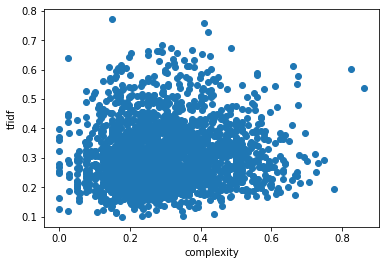

In [338]:
plt.scatter(lcp_single_train_bible['complexity'], lcp_single_train_bible['tfidf'])
plt.xlabel('complexity')
plt.ylabel('tfidf')

In [142]:
path = 'data/bible-corpus-tools/TXT_Bibles/English-WEB.txt'
with open(path) as file:
    external_sentences = [line.strip() for line in file.readlines()]
#v = TfidfVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b')
v = CountVectorizer(lowercase=True, token_pattern = r'(?u)\b\w+\b')
x = v.fit_transform(external_sentences)
matrix = pd.DataFrame(x.toarray(), columns = v.get_feature_names())

In [143]:
def get_tfidf_for_sample(x, v, r, default=1):
    idx = x['idx']
    token = x['token']
    if token in v.vocabulary_:
        return r[idx, v.vocabulary_[token]]
    else:
        if v.lowercase:
            token = token.lower()
            if token in v.vocabulary_:
                return r[idx, v.vocabulary_[token]]
            else:
                return default
        else:
            return default
def get_tf_for_sample(x, r, default=0):
    idx = x['idx']
    token = x['token']
    if token in r:
        return r[token]
    else:
        return 0

In [144]:
#result = v.transform(lcp_single_train['sentence'])
#lcp_single_train_bible['idx'] = range(len(lcp_single_train_bible))
#lcp_single_train_bible['tfidf'] = lcp_single_train_bible.apply(lambda x: get_tfidf_for_sample(x, v, result), axis=1)
x_sum = x.sum(axis=0).tolist()[0]
result = {word: x_sum[idx] for word, idx in v.vocabulary_.items()}
lcp_single_train_bible['tf'] = lcp_single_train_bible.apply(lambda x: get_tf_for_sample(x, result), axis=1)

In [141]:
lcp_single_train_bible[['complexity', 'tfidf']].corr()

complexity     tfidf
complexity    1.000000  0.168078
tfidf         0.168078  1.000000

In [145]:
lcp_single_train_bible[['complexity', 'tf']].corr()

complexity        tf
complexity    1.000000 -0.288992
tf           -0.288992  1.000000

In [58]:
matrix.shape

(31102, 13405)

In [77]:
for token in lcp_single_train_bible['token']:
    if token not in matrix.columns:
        print(token)

In [78]:
to_external = {}
for i, sentence in enumerate(lcp_single_train_bible['sentence']):
    for j, external_sentence in enumerate(external_sentences):
        if sentence in external_sentence:
            to_external[i] = j
            break
    else:
        print('foo')

In [79]:
lcp_single_train_bible['idx'] = range(len(lcp_single_train_bible))
lcp_single_train_bible['tfidf'] = lcp_single_train_bible.apply(lambda x: matrix.loc[to_external[x['idx']], x['token']], axis=1)

In [80]:
lcp_single_train_bible[['complexity','tfidf']].corr()

complexity     tfidf
complexity    1.000000  0.213167
tfidf         0.213167  1.000000

In [159]:
# use-idf=False
lcp_single_train_bible[['complexity','tfidf']].corr()

complexity     tfidf
complexity    1.000000  0.012646
tfidf         0.012646  1.000000

Text(0, 0.5, 'tfidf')

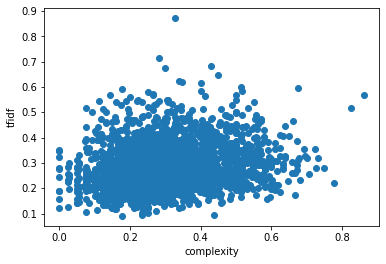

In [345]:
plt.scatter(lcp_single_train_bible['complexity'], lcp_single_train_bible['tfidf'])
plt.xlabel('complexity')
plt.ylabel('tfidf')

Text(0, 0.5, 'tfidf')

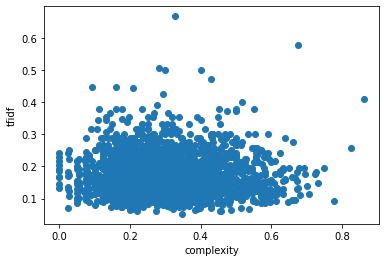

In [144]:
plt.scatter(lcp_single_train_bible['complexity'], lcp_single_train_bible['tfidf'])
plt.xlabel('complexity')
plt.ylabel('tfidf')

In [132]:
lcp_single_train_biomed = lcp_single_train[lcp_single_train['corpus']=='biomed']
v = TfidfVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b')
x = v.fit_transform(lcp_single_train_biomed['sentence'])
matrix = pd.DataFrame(x.toarray(), columns = v.get_feature_names())

In [133]:
lcp_single_train_biomed['idx'] = range(len(lcp_single_train_biomed))
lcp_single_train_biomed['tfidf'] = lcp_single_train_biomed.apply(lambda x: matrix.loc[x['idx'], x['token']], axis=1)

In [348]:
lcp_single_train_biomed[['complexity','tfidf']].corr()

complexity    tfidf
complexity  1.00000     0.10248
tfidf       0.10248     1.00000

In [134]:
# use-idf=False
lcp_single_train_biomed[['complexity','tfidf']].corr()

complexity     tfidf
complexity    1.000000  0.010481
tfidf         0.010481  1.000000

Text(0, 0.5, 'tfidf')

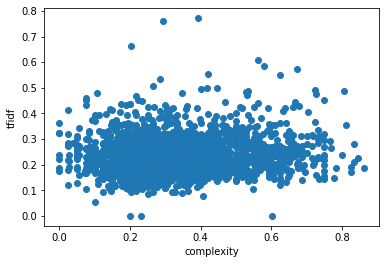

In [349]:
plt.scatter(lcp_single_train_biomed['complexity'], lcp_single_train_biomed['tfidf'])
plt.xlabel('complexity')
plt.ylabel('tfidf')

In [135]:
path = 'data/craft-2.0/articles/txt/'
external_articles = []
for filename in os.listdir(path):
    if filename.endswith('.txt'):
        with open(os.path.join(path, filename), 'r') as file:
            external_articles.append(file.read())

In [136]:
to_external = {}
for i, sentence in enumerate(lcp_single_train_biomed['sentence']):
    sent = sentence.replace('‚Äì','–')
    sent = sent.replace('Œ±','α')
    sent = sent.replace('     ','')
    sent = sent.replace('‚àí','−')
    sent = sent.replace('‚Äò','‘')
    sent = sent.replace('‚Äô','’')
    sent = sent.replace('Œ≤','β')
    sent = sent.replace('Œî','Δ')
    sent = sent.replace('‚Äú','“')
    sent = sent.replace('‚Äù','”')
    sent = sent.replace('√ó','×')
    sent = sent.replace('Œ¥','δ')
    sent = sent.replace('Œº','μ')
    sent = sent.replace('for   CCAAT','forCCAAT')
    sent = sent.replace('‚Ñ¢','™')
    sent = sent.replace('√±','ñ')
    sent = sent.replace('(‚“','(“')
    sent = sent.replace('‚”)','”)')
    sent = sent.replace('‚Äî','—')
    sent = sent.replace('Œ≥','γ')
    sent = sent.replace('√Ö','Å')
    for j, article in enumerate(external_articles):
        if sent in article or article in sent:
            to_external[i] = j
            break
    else:
        print(sentence, '\n')

In [ ]:
[article for article in external_articles if 'Animals carrying the at allele' in article]

In [137]:
x = v.fit_transform(external_articles)
matrix = pd.DataFrame(x.toarray(), columns = v.get_feature_names())

In [138]:
matrix.shape

(67, 21986)

In [139]:
for token in lcp_single_train_biomed['token']:
    if token not in matrix.columns:
        print(token)

In [140]:
lcp_single_train_biomed['idx'] = range(len(lcp_single_train_biomed))
lcp_single_train_biomed['tfidf'] = lcp_single_train_biomed.apply(lambda x: matrix.loc[to_external[x['idx']], x['token']], axis=1)

In [357]:
lcp_single_train_biomed[['complexity','tfidf']].corr()

complexity     tfidf
complexity  1.000000    0.201372
tfidf       0.201372    1.000000

In [141]:
# use-idf=False
lcp_single_train_biomed[['complexity','tfidf']].corr()

complexity     tfidf
complexity    1.000000  0.119035
tfidf         0.119035  1.000000

Text(0, 0.5, 'tfidf')

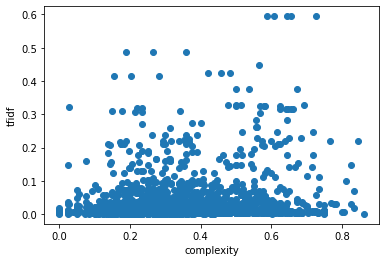

In [358]:
plt.scatter(lcp_single_train_biomed['complexity'], lcp_single_train_biomed['tfidf'])
plt.xlabel('complexity')
plt.ylabel('tfidf')

Text(0, 0.5, 'tfidf')

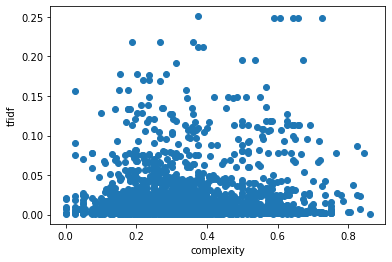

In [142]:
plt.scatter(lcp_single_train_biomed['complexity'], lcp_single_train_biomed['tfidf'])
plt.xlabel('complexity')
plt.ylabel('tfidf')

Re-run the TF-IDF experiment but using TF only and see the correlations
- Slight improvements (see #use_idf=False cells above)

Might make sense to do our TF or TF-IDF analysis again using n-grams and see if its direct surrounding words matter more than the words themselves.

In [381]:
lcp_single_train_bible = lcp_single_train[lcp_single_train['corpus']=='bible']
complexities = lcp_single_train_bible['complexity']
v = TfidfVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b', ngram_range=(3,3))
path = 'data/bible-corpus-tools/TXT_Bibles/English-WEB.txt'
with open(path) as file:
    external_sentences = [line.strip() for line in file.readlines()]
x = v.fit_transform(external_sentences).toarray()
features = v.get_feature_names()

In [382]:
to_external = []
for i, sentence in enumerate(lcp_single_train_bible['sentence']):
    for j, external_sentence in enumerate(external_sentences):
        if sentence in external_sentence:
            to_external.append(j)
            break
    else:
        print('foo')

In [383]:
x = x[np.array(to_external), :]
x.shape

(2312, 385339)

In [420]:
x = glove(lcp_single_train_bible, embeddings_dict, True)
x = x[:,:300]

In [421]:
pca = PCA(n_components=3)
x_pca = pca.fit(x).transform(x)
x_pca.shape

(2312, 3)

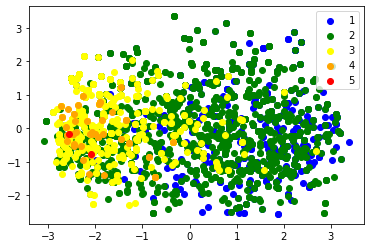

In [418]:
colors = ['red', 'orange', 'yellow', 'green', 'blue'][::-1]
for i, cls in enumerate(lcp_single_train_bible['class'].unique()):
    plt.scatter(x_pca[lcp_single_train_bible.reset_index()['class'] == cls, 0], 
                x_pca[lcp_single_train_bible.reset_index()['class'] == cls, 1], 
                color=colors[i], label=cls)
plt.legend(loc='best')

In [340]:
feature_dict = dict(zip(features, range(len(features))))

In [343]:
avg_tfidf = []
cv = CountVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b', ngram_range=(1,1))
for i in tqdm(range(len(lcp_single_train_bible))):
    sentence = lcp_single_train_bible.iloc[i]['sentence']
    aspect = lcp_single_train_bible.iloc[i]['token']
    cv.fit([sentence])
    feature_lst = [feature for j, feature in enumerate(cv.get_feature_names()) if aspect in feature]
    avg_tfidf.append(x[i, np.array([feature_dict[feature] for feature in feature_lst])].mean())

100%|██████████| 2312/2312 [00:06<00:00, 382.92it/s]


In [344]:
np.corrcoef(complexities, avg_tfidf)[0, 1]

0.21316658535494865

In [60]:
np.corrcoef(complexities, avg_tfidf)[0, 1]

0.12388856057233803

In [67]:
np.corrcoef(complexities, avg_tfidf)[0, 1]

0.06641526183325222

In [120]:
lcp_single_train_biomed = lcp_single_train[lcp_single_train['corpus']=='biomed']
complexities = lcp_single_train_biomed['complexity']
v = TfidfVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b', ngram_range=(3,3))
path = 'data/craft-2.0/articles/txt/'
external_articles = []
for filename in os.listdir(path):
    if filename.endswith('.txt'):
        with open(os.path.join(path, filename), 'r') as file:
            external_articles.append(file.read())
x = v.fit_transform(external_articles).toarray()
features = v.get_feature_names()

In [121]:
to_external = []
for i, sentence in enumerate(lcp_single_train_biomed['sentence']):
    sent = sentence.replace('‚Äì','–')
    sent = sent.replace('Œ±','α')
    sent = sent.replace('     ','')
    sent = sent.replace('‚àí','−')
    sent = sent.replace('‚Äò','‘')
    sent = sent.replace('‚Äô','’')
    sent = sent.replace('Œ≤','β')
    sent = sent.replace('Œî','Δ')
    sent = sent.replace('‚Äú','“')
    sent = sent.replace('‚Äù','”')
    sent = sent.replace('√ó','×')
    sent = sent.replace('Œ¥','δ')
    sent = sent.replace('Œº','μ')
    sent = sent.replace('for   CCAAT','forCCAAT')
    sent = sent.replace('‚Ñ¢','™')
    sent = sent.replace('√±','ñ')
    sent = sent.replace('(‚“','(“')
    sent = sent.replace('‚”)','”)')
    sent = sent.replace('‚Äî','—')
    sent = sent.replace('Œ≥','γ')
    sent = sent.replace('√Ö','Å')
    for j, article in enumerate(external_articles):
        if sent in article or article in sent:
            to_external.append(j)
            break
    else:
        print(sentence, '\n')

In [122]:
x = x[np.array(to_external), :]
x.shape

(2314, 346466)

In [123]:
feature_dict = dict(zip(features, range(len(features))))

In [129]:
avg_tfidf = []
cv = CountVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b', ngram_range=(3,3))
for i in tqdm(range(len(lcp_single_train_biomed))):
    if i == 1170:
        avg_tfidf.append(0)
        continue
    sentence = lcp_single_train_biomed.iloc[i]['sentence']
    sent = sentence.replace('‚Äì','–')
    sent = sent.replace('Œ±','α')
    sent = sent.replace('     ','')
    sent = sent.replace('‚àí','−')
    sent = sent.replace('‚Äò','‘')
    sent = sent.replace('‚Äô','’')
    sent = sent.replace('Œ≤','β')
    sent = sent.replace('Œî','Δ')
    sent = sent.replace('‚Äú','“')
    sent = sent.replace('‚Äù','”')
    sent = sent.replace('√ó','×')
    sent = sent.replace('Œ¥','δ')
    sent = sent.replace('Œº','μ')
    sent = sent.replace('for   CCAAT','forCCAAT')
    sent = sent.replace('‚Ñ¢','™')
    sent = sent.replace('√±','ñ')
    sent = sent.replace('(‚“','(“')
    sent = sent.replace('‚”)','”)')
    sent = sent.replace('‚Äî','—')
    sent = sent.replace('Œ≥','γ')
    sent = sent.replace('√Ö','Å')
    aspect = lcp_single_train_biomed.iloc[i]['token']
    try:
        cv.fit([sent])
    except:
        print('foo')
        avg_tfidf.append(0)
        continue
    feature_lst = [feature for j, feature in enumerate(cv.get_feature_names()) if aspect in feature]
    avg_tfidf.append(x[i, np.array([feature_dict[feature] for feature in feature_lst])].mean())

100%|██████████| 2314/2314 [00:05<00:00, 440.99it/s]


In [113]:
np.corrcoef(complexities, avg_tfidf)[0, 1]

0.20145578123023616

In [119]:
np.corrcoef(complexities, avg_tfidf)[0, 1]

0.13621726828466113

In [130]:
np.corrcoef(complexities, avg_tfidf)[0, 1]

0.05431532288488144

Character n-gram

In [229]:
lcp_single_train_bible = lcp_single_train[lcp_single_train['corpus']=='bible']
complexities = lcp_single_train_bible['complexity']
v = CountVectorizer(#lowercase=False,
                    ngram_range=(2,2),
                    token_pattern = r"(?u)\b\w+\b", 
                    analyzer='char')
x = v.fit_transform(lcp_single_train['token']).toarray()
features = np.array(v.get_feature_names())
'''
v = TfidfVectorizer(lowercase=False, token_pattern = r'(?u)\b\w+\b', ngram_range=(3,3))
path = 'data/bible-corpus-tools/TXT_Bibles/English-WEB.txt'
with open(path) as file:
    external_sentences = [line.strip() for line in file.readlines()]
x = v.fit_transform(external_sentences).toarray()
features = v.get_feature_names()'''

"\nv = TfidfVectorizer(lowercase=False, token_pattern = r'(?u)\x08\\w+\x08', ngram_range=(3,3))\npath = 'data/bible-corpus-tools/TXT_Bibles/English-WEB.txt'\nwith open(path) as file:\n    external_sentences = [line.strip() for line in file.readlines()]\nx = v.fit_transform(external_sentences).toarray()\nfeatures = v.get_feature_names()"

In [230]:
complexity = lcp_single_train['complexity'].to_numpy()

In [231]:
corrs = []
for column in x.T:
    corrs.append(np.corrcoef(complexity, column)[0,1])
corrs = np.array(corrs)

In [232]:
features[np.abs(corrs).argsort()][::-1]

array(['ph', 'ea', 'os', 'ia', 'ou', 'ca', 'cf', 'kb', 'li', 'ub', 'og',
       'hg', 'oc', 'eo', 'iu', 'ad', 'bu', 'hy', 'yn', 'fa', 'it', 'ez',
       'bi', 'na', 'ha', 'gh', 'aa', 'hh', 'ah', 'ct', 'ts', 'hr', 'ev',
       'ci', 'eu', 'yw', 'nd', 'ht', 'gl', 'wo', 'xx', 'um', 'il', 'ti',
       'wi', 'sm', 'yr', 'zz', 'ga', 'iq', 'yt', 'at', 'dr', 'ey', 'eb',
       'hs', 'ra', 'ri', 'et', 'sa', 'za', 'yc', 'da', 'ld', 'rp', 'mi',
       'ay', 'ni', 'ig', 'hl', 'ym', 'ze', 'lu', 'ye', 'se', 'is', 'ee',
       'ko', 'io', 'wk', 'sy', 'ui', 'uo', 'xy', 've', 'by', 'oo', 'nt',
       'ab', 'rv', 'rt', 'mn', 'fi', 'ae', 'vi', 'ml', 'un', 'bg', 'to',
       'mu', 'cr', 'go', 'ka', 'ow', 'la', 'dm', 'kc', 'lo', 'cl', 'md',
       'sk', 'cn', 'pe', 'uc', 'po', 'oh', 'ib', 'ma', 'rs', 'on', 'qu',
       'gs', 'cy', 'yg', 'sw', 'tc', 'ir', 'xp', 'zi', 'ky', 'xt', 'al',
       'we', 'kn', 'te', 'll', 'gr', 'ms', 'bb', 'th', 'ws', 'cc', 'he',
       'cu', 'lb', 'cm', 'el', 'me', 'ng', 'ur', 'f

In [233]:
np.corrcoef(complexity, x[:, np.where(features=='ph')[0][0]])[0,1]

0.14955645853697208

In [234]:
lcp_single_train['ngram_ph'] = x[:, np.where(features=='ph')[0][0]]

In [236]:
lcp_single_train.groupby(['class'])['ngram_ph'].describe()

count      mean       std  min  25%  50%  75%  max
class                                                     
1      1544.0  0.003238  0.056833  0.0  0.0  0.0  0.0  1.0
2      3964.0  0.009082  0.094876  0.0  0.0  0.0  0.0  1.0
3      1162.0  0.031842  0.175654  0.0  0.0  0.0  0.0  1.0
4       205.0  0.126829  0.375098  0.0  0.0  0.0  0.0  2.0
5        10.0  0.100000  0.316228  0.0  0.0  0.0  0.0  1.0

What about we count the BPEs (word pieces returned by the tokenizer, with “##” removed) instead?

We can use the summed TF for all the BPEs per aspect word then.

In [398]:
path = 'data/bible-corpus-tools/TXT_Bibles/English-WEB.txt'
with open(path) as file:
    external_sentences = [line.strip() for line in file.readlines()]

In [399]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
external_BPEs = []
for idx, sentence in tqdm(enumerate(external_sentences)):
    BPEs = tokenizer.tokenize(sentence)
    BPEs = [BPE.strip('##') for BPE in BPEs]
    external_BPEs.append(' '.join(BPEs))

Downloading: 100%|██████████| 213k/213k [00:00<00:00, 1.21MB/s]
31102it [00:24, 1256.76it/s]


In [401]:
external_sentences[1], external_BPEs[1]

("Now the earth was formless and empty. Darkness was on the surface of the deep. God's Spirit was hovering over the surface of the waters.",
 "Now the earth was form less and empty . Darkness was on the surface of the deep . God ' s Spirit was hovering over the surface of the waters .")

In [637]:
v = CountVectorizer(lowercase=False,
                    ngram_range=(1,1),
                    token_pattern = r"(?u)\b\w+\b")
x = v.fit_transform(external_BPEs).toarray()

In [638]:
BPE_to_TF = dict(zip(v.get_feature_names(), x.sum(axis=0)))

In [639]:
sentences = lcp_single_train_bible['sentence']

In [640]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
summed_TF = []
for idx, sentence in tqdm(enumerate(sentences)):
    BPEs = tokenizer.tokenize(sentence)
    BPEs = [BPE.strip('##') for BPE in BPEs]
    summed_TF.append(sum([BPE_to_TF[BPE] if BPE in BPE_to_TF else 0 for BPE in BPEs]))
    if idx == 1667:
        break

1667it [00:02, 752.49it/s]


In [602]:
lcp_single_train_bible['summed_TF'] = summed_TF

Text(0, 0.5, 'complexity')

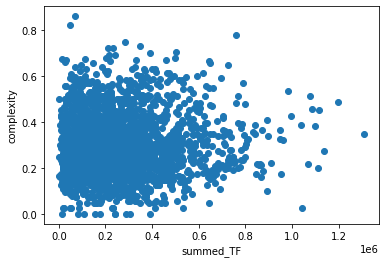

In [604]:
plt.scatter(lcp_single_train_bible['summed_TF'], lcp_single_train_bible['complexity'])
plt.xlabel('summed_TF')
plt.ylabel('complexity')

In [654]:
lcp_single_train_bible['aspect_word_TF'] = lcp_single_train_bible['token'].apply(lambda x: sum([BPE_to_TF[BPE] for BPE in tokenizer.tokenize(x) if BPE in BPE_to_TF]))

Text(0, 0.5, 'complexity')

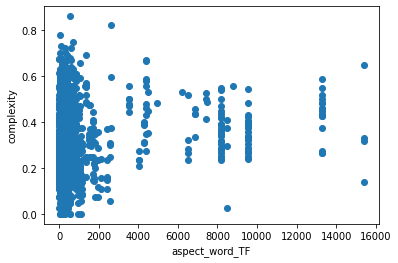

In [656]:
plt.scatter(lcp_single_train_bible['aspect_word_TF'], lcp_single_train_bible['complexity'])
plt.xlabel('aspect_word_TF')
plt.ylabel('complexity')

In [657]:
lcp_single_train_bible[['complexity','aspect_word_TF']].corr()

complexity  aspect_word_TF
complexity      1.000000    0.156606      
aspect_word_TF  0.156606    1.000000

Examine samples with same aspect words but different contexts. Check what makes the same aspect word more complex in the dataset?

In [701]:
sentence = 'However, the development of safe and effective secretase inhibitors will ultimately be required to determine whether the human brain has the capacity to repair amyloid-associated damage of AD once the progression of pathology is arrested.'
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [707]:
lcp_single_train['dev'] = lcp_single_train.apply(lambda x: np.mean([len(word) for word in word_tokenize(x['sentence'])if word not in string.punctuation]), axis=1)

In [761]:
del duplicated_tokens['dev']

In [757]:
duplicated_tokens = lcp_single_train[lcp_single_train.duplicated('token', keep=False)].sort_values(['token', 'complexity'])
duplicated_tokens.groupby('token')['complexity'].apply(lambda x: max(x)-min(x)).sort_values(ascending=False)[:20]

token
search            0.475000
byword            0.450000
activity          0.400000
thrombus          0.356061
Cre               0.354412
correlation       0.350446
reversal          0.348529
flock             0.342308
precursors        0.330882
mo                0.330882
Nebuchadnezzar    0.330263
cherubim          0.321637
lion              0.315789
Micah             0.311275
KO                0.309524
member            0.308333
Tent              0.304487
fire              0.303571
others            0.303125
weeks             0.301087
Name: complexity, dtype: float64

In [773]:
duplicated_tokens[duplicated_tokens['token']=='weeks']

id    corpus  \
2595  3FW4EL5A3LORTQISN5M9XK6XOSY22B  biomed     
5161  3W0XM68YZPVFLL4MT7SZSXIMDN81KJ  europarl   
2596  3PGQRAZX02KAZASXA58AX6K611XYSW  biomed     

                                                                                                                                                                         sentence  \
2595  Another possible explanation is that the premature death in first 2 weeks of life is caused by the dysfunction of the autonomic nervous system.                               
5161  (FR) Ladies and gentlemen, a European final, who would have believed it only a few weeks ago?                                                                                 
2596  Especially, nerves which control the breathing would be very important, because the respiration system undergoes significant maturation in the first 2–3 weeks after birth.   

      token  complexity class  
2595  weeks  0.025000    1     
5161  weeks  0.250000    2     
2596  weeks  0.326087    2

In [745]:
wordfreq.word_frequency('correlation', 'en')

6.46e-06

In [724]:
[item for item in lcp_single_train.groupby('sentence')['token'].apply(list).tolist() if len(item) != len(set(item))]

[['dogma', 'dogma'],
 ['cohorts', 'cohorts'],
 ['precursors', 'precursors'],
 ['search', 'search']]

In [735]:
duplicated_tokens[duplicated_tokens['token']=='search']

id  corpus  \
2667  3087LXLJ6MG4YARQWDX2YF770YK0FA  biomed   
2668  3JYPJ2TAYI87MRVADYCSDG8F86VFPV  biomed   
92    3YLTXLH3DF6R0NMG8O0SG1KSOLOPHJ  bible    
2669  36BTXXLZ2V8I0OE069KYR7B3KZ8R4B  biomed   
93    3UEDKCTP9VQTW7JOIN98T79ZG6B7KJ  bible    
2670  3ECKRY5B1QWLAMZ61FGF7BNLYYRZIQ  biomed   

                                                                                                                                                                                                                                                                                                        sentence  \
2667  Thus, our observations provide unexpected starting-points in the search for huntingtin's precise molecular activities, which began with the discovery that this HEAT domain protein hosts the dominant polyglutamine property that is the fundamental basis of HD pathogenesis.                              
2668  For this study, an inducible, liver-specific Mtf1 knockout mouse line was generated to perform a search for MTF-1 target genes and cadmium-inducible genes in the adult liver.                                                                                                                               
92    Now therefore, if it seem good to the king, let a search be made in the king's treasure house, which is there at Babylon, whether it be so, that a decree was made of Cyrus the king to build this house of God at Jerusalem; and let the king send his pleasure to us concerning this matter."              
2669  A previous target gene search for MTF-1 with mouse embryos of conventional Mtf1 knockout phenotype revealed, besides metallothionein genes, the multifunctional alpha-fetoprotein (Afp) and the liver-enriched transcription factor CCAAT/enhancer binding protein alpha (Cebpa) as prime candidates (65).   
93    Then Darius the king made a decree, and search was made in the house of the archives, where the treasures were laid up in Babylon.                                                                                                                                                                           
2670  Thus, our observations provide unexpected starting-points in the search for huntingtin's precise molecular activities, which began with the discovery that this HEAT domain protein hosts the dominant polyglutamine property that is the fundamental basis of HD pathogenesis.                              

       token  complexity class       dev  
2667  search  0.050000    1     6.105263  
2668  search  0.083333    1     5.370370  
92    search  0.166667    1     3.813559  
2669  search  0.229167    2     6.837838  
93    search  0.250000    2     4.120000  
2670  search  0.525000    3     6.105263

Feature-selection using mutual info
- see OneNote.
- see Colab.

In [68]:
def build_library(data, config):
    library = {}
    library['glove_embeddings'] = {}
    with open(config['glove_path'], 'r', encoding="utf-8") as f:
        for line in tqdm(f):
            values = line.split()
            word = ''.join(values[:-300])
            coefs = np.asarray(values[-300:], dtype='float32')
            library['glove_embeddings'][word] = coefs
    library['infersent_embeddings'] = {}
    V = config['infersent_V']
    MODEL_PATH = config['infersent_MODEL_PATH'] % V
    W2V_PATH = config['infersent_W2V_PATH']
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
    infersent = InferSent(params_model)
    infersent.load_state_dict(torch.load(MODEL_PATH))
    infersent.set_w2v_path(W2V_PATH)
    if config['infersent_lower']:
        sentences = data['sentence'].str.lower().tolist()
    else:
        sentences = data['sentence'].tolist()
    infersent.build_vocab(sentences, tokenize=True)
    library['infersent_embeddings'] = infersent.encode(sentences, tokenize=True)
    library['parse_lst'] = pkl.load(open(config['parse_lst_path'], 'rb'))
    return library

In [69]:
def names(features):
    result = []
    for basename in features:
        if features[basename].ndim == 1:
            result.append(basename)
        else:
            for i in range(1, features[basename].shape[1]+1):
                result.append('{}_{}'.format(basename, i))
    return result

In [70]:
def discrete(features):
    result = []
    for basename in features:
        #print(basename, '\t',features[basename].dtype)
        #continue
        is_discrete = None
        if issubclass(features[basename].dtype.type, np.integer):
            is_discrete = True
        else:
            is_discrete = False
        if features[basename].ndim == 1:
            result.append(is_discrete)
        else:
            for i in range(features[basename].shape[1]):
                result.append(is_discrete)
    return result

In [1061]:
def feature_selection(data, library, config):
    features = {}
    # based on token
    features['word_len'] = data['token'].str.len().to_numpy()
    features['num_syllables'] = data['token'].apply(lambda x: syllables.estimate(str(x))).to_numpy()
    features['glove_word'] = glove_word(data, library['glove_embeddings'], lower=config['glove_lower'])
    features['num_hyponyms'] = data.apply(lambda x: len(get_hyponyms(x['sentence'], x['token'], disambiguate=config['disambiguate'])), axis=1).to_numpy()
    features['num_hypernyms'] = data.apply(lambda x: len(get_hypernyms(x['sentence'], x['token'], disambiguate=config['disambiguate'])), axis=1).to_numpy()
    features['is_acronym'] = (data['token'].str.isupper()*1).to_numpy()
    features['is_pronoun'] = (data['token'].apply(lambda x: x[0].isupper())*1).to_numpy()
    POS = pd.get_dummies(data.apply(lambda x: get_POS(x['sentence'], x['token']), axis=1), prefix='POS')
    for tag in POS:
        features[tag] = POS[tag].to_numpy()
    # based on sentence
    features['glove_sentence'] = glove_context(data, library['glove_embeddings'], lower=config['glove_lower'])
    features['infersent_embeddings'] = library['infersent_embeddings']
    funcs = ["textstat." + func[0] for func in inspect.getmembers(textstat, predicate=inspect.ismethod)]
    for elem in tqdm(funcs):
        method = eval(elem)
        if method.__name__ in ['difficult_words_list', 'set_lang', 'text_standard', 'dale_chall_readability_score_v2', 'dale_chall_readability_score', 'gunning_fog', 'spache_readability', 'avg_sentence_length', 'avg_sentence_per_word', 'sentence_count', 'difficult_words', 'is_difficult_word', 'is_easy_word', 'smog_index']:
            continue
        #print(method.__name__)
        textstat.set_lang("en")
        features[method.__name__] = data['sentence'].apply(lambda x: method(x)).to_numpy()
    features['SMOGIndex'] = data['sentence'].apply(lambda x: readability.getmeasures(x, lang='en')['readability grades']['SMOGIndex']).to_numpy()
    features['DaleChallIndex'] = data['sentence'].apply(lambda x: readability.getmeasures(x, lang='en')['readability grades']['DaleChallIndex']).to_numpy()
    parse_tree_depths = []
    token_depths = []
    num_words_at_depths = []
    for parse, token in tqdm(zip(parse_lst, data['token'])):
        parse_tree_depths.append(parse.height())
        token_depths.append(token_depth(parse, token))
        num_words_at_depths.append(num_words_at_depth(parse, token_depths[-1]))
    features['parse_tree_depth'] = np.array(parse_tree_depths).astype(np.int64)
    features['token_depth'] = np.array(token_depths).astype(np.int64)
    features['num_words_at_depth'] = np.array(num_words_at_depths).astype(np.int64)
    #features_stacked = np.hstack([item[:,None] if item.ndim==1 else item for item in features.values()])
    #complexity = data['complexity'].to_numpy()
    #discrete_features = discrete(features)

    # done
    return features

In [60]:
config = {
    'glove_path': "./data/glove/glove.6B.300d.txt",
    'glove_lower': True,
    'disambiguate': True,
    'infersent_V': 1,
    'infersent_MODEL_PATH': './data/encoder/infersent%s.pkl',
    'infersent_W2V_PATH': './data/glove/glove.6B.300d.txt',
    'infersent_lower': True,
    'parse_lst_path': './data/parse_lst_6885.pkl',
}

In [75]:
#library = build_library(lcp_single_train, config)
features = feature_selection(lcp_single_train, library, config)

100%|██████████| 34/34 [00:20<00:00,  1.68it/s]
3515it [00:21, 161.60it/s]foo
6885it [00:50, 137.55it/s]


In [1062]:
del features['word_freq']

In [1063]:
with open('./macbook_features.pkl', 'wb') as file:
    pkl.dump(features, file)

In [ ]:
with open('/Volumes/f0035qc/feature_selection/macbook_features.pkl', 'wb') as file:
    pkl.dump(features, file)

In [89]:
def apply_pca(data, n_components=0.95):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)
    return scaler, pca, pca_data

In [90]:
scaler_gw, pca_gw, features['glove_word_pca'] = apply_pca(features['glove_word'], 0.95)
scaler_gs, pca_gs, features['glove_sentence_pca'] = apply_pca(features['glove_sentence'], 0.95)
scaler_ie, pca_ie, features['infersent_embeddings_pca'] = apply_pca(features['infersent_embeddings'], 0.95)

In [92]:
features['glove_word_pca'].shape, features['glove_sentence_pca'].shape, features['infersent_embeddings_pca'].shape

((6885, 196), (6885, 166), (6885, 1938))

In [38]:
_glove_word = features['glove_word']
_glove_sentence = features['glove_sentence']
_infersent_embeddings = features['infersent_embeddings']
del features['glove_word']
del features['glove_sentence']
del features['infersent_embeddings']

In [76]:
features.keys()

dict_keys(['word_freq', 'word_len', 'num_syllables', 'glove_word', 'num_hyponyms', 'num_hypernyms', 'is_acronym', 'is_pronoun', 'POS_CC', 'POS_CD', 'POS_DT', 'POS_FW', 'POS_IN', 'POS_JJ', 'POS_JJR', 'POS_JJS', 'POS_NN', 'POS_NNP', 'POS_NNPS', 'POS_NNS', 'POS_PDT', 'POS_RB', 'POS_RP', 'POS_VB', 'POS_VBD', 'POS_VBG', 'POS_VBN', 'POS_VBP', 'POS_VBZ', 'POS_WP', 'POS_WRB', 'glove_sentence', 'infersent_embeddings', 'automated_readability_index', 'avg_character_per_word', 'avg_letter_per_word', 'avg_syllables_per_word', 'char_count', 'coleman_liau_index', 'crawford', 'fernandez_huerta', 'flesch_kincaid_grade', 'flesch_reading_ease', 'gutierrez_polini', 'letter_count', 'lexicon_count', 'linsear_write_formula', 'lix', 'polysyllabcount', 'reading_time', 'rix', 'syllable_count', 'szigriszt_pazos', 'SMOGIndex', 'DaleChallIndex', 'parse_tree_depth', 'token_depth', 'num_words_at_depth'])

In [ ]:
for basename in features:
    print(basename, features[basename].dtype)

In [ ]:
names(features)

In [42]:
features_stacked = np.hstack([item[:,None] if item.ndim == 1 else item for item in features.values()])
complexity = lcp_single_train['complexity'].to_numpy()

In [43]:
discrete_features = discrete(features)

In [46]:
features_stacked.shape

(6885, 2352)

In [503]:
%%time
mi = mutual_info_regression(features_stacked, complexity, discrete_features=discrete_features)

CPU times: user 2min 52s, sys: 3.52 s, total: 2min 56s
Wall time: 2min 58s


In [504]:
x = np.corrcoef(features['glove_word_pca'][:,0], complexity)
x

array([[ 1.        , -0.57028881],
       [-0.57028881,  1.        ]])

In [510]:
features.keys()

dict_keys(['word_freq', 'word_len', 'num_syllables', 'num_hyponyms', 'num_hypernyms', 'is_acronym', 'is_pronoun', 'POS_CC', 'POS_CD', 'POS_DT', 'POS_FW', 'POS_IN', 'POS_JJ', 'POS_JJR', 'POS_JJS', 'POS_NN', 'POS_NNP', 'POS_NNPS', 'POS_NNS', 'POS_PDT', 'POS_RB', 'POS_RP', 'POS_VB', 'POS_VBD', 'POS_VBG', 'POS_VBN', 'POS_VBP', 'POS_VBZ', 'POS_WP', 'POS_WRB', 'avg_character_per_word', 'avg_letter_per_word', 'avg_sentence_length', 'avg_sentence_per_word', 'avg_syllables_per_word', 'char_count', 'coleman_liau_index', 'dale_chall_readability_score', 'dale_chall_readability_score_v2', 'difficult_words', 'flesch_kincaid_grade', 'flesch_reading_ease', 'gunning_fog', 'letter_count', 'lexicon_count', 'linsear_write_formula', 'lix', 'polysyllabcount', 'reading_time', 'rix', 'sentence_count', 'smog_index', 'spache_readability', 'syllable_count', 'glove_word_pca', 'glove_sentence_pca', 'infersent_embeddings_pca'])

In [ ]:
features.keys()

In [ ]:
sorted(list(zip(names(features), mi)), key=lambda x: x[1], reverse=True)#[:100]

In [ ]:
for item in features.values():
    print(item.shape)

In [ ]:
import datasets
from datasets import load_dataset
dataset = load_dataset("gigaword", split='train+validation+test')
dataset.remove_columns_('summary')
gigaword_sentences = dataset['document']

In [198]:
def ChunkIterator(doc_files):
  for doc in doc_files:
    yield doc

In [199]:
v = TfidfVectorizer(lowercase=True, token_pattern = r'(?u)\b\w+\b')
v.fit(ChunkIterator(gigaword_sentences))

TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')

In [216]:
vocab = v.vocabulary_

In [218]:
word = 'unbeliever'
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize(word))
ps = PorterStemmer()
print(ps.stem(word))

unbeliever
unbeliev


In [219]:
result = []
for idx, row in lcp_single_train.iterrows():
    sentence = row['sentence'].lower()
    token = row['token'].lower()
    scores = v.transform([sentence]).toarray()[0]
    if token in vocab:
        result.append(scores[vocab[token]])
    else:
        token_stemmed = ps.stem(token)
        if token_stemmed in vocab:
            result.append(scores[vocab[token_stemmed]])
        else:
            token_lemmatized = ps.stem(token)
            if token_lemmatized in vocab:
                result.append(scores[vocab[token_lemmatized]])
            else:
                result.append(np.nan)
result = np.array(result)

In [220]:
lcp_single_train['tfidf'] = result

In [235]:
len(vocab)

98690

In [130]:
lcp_single_train[lcp_single_train['tfidf'].isna()].groupby('corpus').size()

corpus
bible       200
biomed      249
europarl     30
dtype: int64

In [221]:
lcp_single_train[lcp_single_train['tfidf'].isna()].groupby('corpus').size()

corpus
bible       200
biomed      249
europarl     30
dtype: int64

In [234]:
lcp_single_train[lcp_single_train['tfidf'].isna() ][lcp_single_train['corpus']=='europarl']['token'].tolist()

['gremlin',
 'brickwork',
 'programmes',
 'draftsmen',
 'flavouring',
 'thereabouts',
 'competences',
 'programmes',
 'programmes',
 'transposition',
 'draftsmen',
 'GUE',
 'indent',
 'stabilisers',
 'rigour',
 'ECON',
 'transposition',
 'GUE',
 'modulation',
 'cartography',
 'modulation',
 'Golgotha',
 'draftsmen',
 'SYN',
 'stabilisers',
 'MSS',
 'indent',
 'immobility',
 'boatswain',
 'Quod']

In [58]:
result = v.transform(['pugnacious man'])#.toarray()
for word, score in zip(v.get_feature_names(), result[0]):
    if score > 0:
        print(word, score)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [8]:
lcp_single_train.head()

id corpus  \
218  3UUSLRKAUL3LI1DEQ6NLPUE9WZQD7S  bible   
877  3VDI8GSXAFTSUZSO21GZ9FD1KBC8GK  bible   
415  344M16OZKIFFDSJ128FUR9IKWQ1EN2  bible   
309  39XCQ6V3KY47AOKGSQ0AL4QLO7856D  bible   
502  3S8APUMBJXJ5IXU0UTURIW3QR0XFBN  bible   

                                              sentence      token  complexity  \
218  Haman recounted to them the glory of his riche...   servants    0.176471   
877  As they were making their hearts merry, behold...     hearts    0.191176   
415     How much better it is to get wisdom than gold!     wisdom    0.142857   
309  The sun will be darkened in its going forth, a...      light    0.181818   
502  being approved by good works, if she has broug...  strangers    0.132353   

    class  
218     1  
877     1  
415     1  
309     1  
502     1

Elmo

In [719]:
from allennlp.modules.elmo import Elmo, batch_to_ids

In [720]:
options_file = './data/ELMo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'
weight_file = './data/ELMo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'
elmo = Elmo(options_file, weight_file, 1, dropout=0)

In [747]:
sentences = [word_tokenize(sentence) for sentence in lcp_single_train['sentence']]

In [758]:
def batches(iterable, n=1):
    l = len(iterable)
    result = []
    for ndx in range(0, l, n):
        result.append(iterable[ndx:min(ndx + n, l)])
    return result

In [762]:
embeddings_lst = []
for batch in tqdm(batches(sentences, 100)):
    character_ids = batch_to_ids(batch)
    embeddings = elmo(character_ids)
    embeddings_lst.append(embeddings)

100%|██████████| 69/69 [29:03<00:00, 25.26s/it]


In [912]:
embeddings_lst[0]['elmo_representations'][0].shape

torch.Size([100, 69, 1024])

In [898]:
elmo = np.zeros((len(sentences), 1024))
idx = 0
count = 0
for embeddings in tqdm(embeddings_lst):
    e = embeddings['elmo_representations'][0].detach().numpy()
    for i in range(e.shape[0]):
        token = lcp_single_train.iloc[idx]['token']
        for j, word in enumerate(sentences[idx]):
            if token == word or token in word:
                break
        else:
            j = None
            count += 1
        if j:
            elmo[idx] = e[i, j]
        else:
            elmo[idx] = 0
        idx += 1
print(count)

100%|██████████| 69/69 [00:08<00:00,  8.02it/s]1



In [959]:
#pkl.dump(elmo, open('elmo_6885.pkl', 'wb'))
elmo = pkl.load(open('data/elmo_6885.pkl', 'rb'))

Elmo PCA

In [965]:
lst = []
#lst = lst.tolist()
for _ in tqdm(range(30)):
    sub_list = []
    for value in np.arange(0.75, 1.049, 0.05):
        if value >= 1.0:
            value = 1024
        scaler, pca, pca_data = apply_pca(elmo, n_components=value)
        X_train, X_test, y_train, y_test = train_test_split(pca_data, lcp_single_train['complexity'], test_size=0.1)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        MAE = mean_absolute_error(y_test_pred, y_test)
        #print(np.round(value, 2), MAE)
        sub_lst.append(MAE)
    lst.append(sub_lst)

100%|██████████| 30/30 [09:55<00:00, 19.85s/it]


In [966]:
lst = np.array(lst)

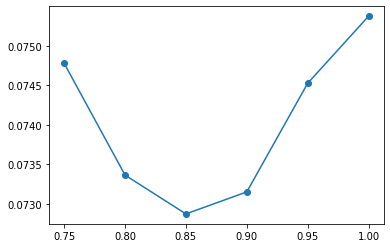

In [976]:
plt.scatter(np.arange(0.75, 1.049, 0.05), lst.mean(axis=0))
plt.plot(np.arange(0.75, 1.049, 0.05), lst.mean(axis=0))

PCA = 0.85

Glove PCA

In [930]:
glove = glove_word(lcp_single_train, embeddings_dict, True)

In [949]:
lst = []
#lst = lst.tolist()
for _ in tqdm(range(50)):
    sub_lst = []
    for value in np.arange(0.85, 1.049, 0.05):
        if value == 1.0:
            value = 300
        scaler, pca, pca_data = apply_pca(glove, n_components=value)
        X_train, X_test, y_train, y_test = train_test_split(pca_data, lcp_single_train['complexity'], test_size=0.1)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        MAE = mean_absolute_error(y_test_pred, y_test)
        #print(np.round(value, 2), MAE)
        sub_lst.append(MAE)
    lst.append(sub_lst)

100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


In [950]:
lst = np.array(lst)

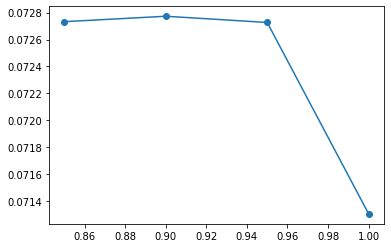

In [951]:
plt.scatter(np.arange(0.85, 1.049, 0.05), lst.mean(axis=0))
plt.plot(np.arange(0.85, 1.049, 0.05), lst.mean(axis=0))

No PCA 

Upon inspection of mutual information scores on discovery, results look great. OK let’s try simply appending the TF-summed feature to GloVe embeddings (with scaling) and see how the linear regression model performs.

In [622]:
lcp_single_train['tf_summed_bpe'] = pd.read_csv('./data/from_discovery_or_colab/lcp_single_train_tf_summed_bpe.tsv', sep='\t', index_col=0)['tf_summed_bpe'].to_numpy()
lcp_single_dev['tf_summed_bpe'] = pd.read_csv('./data/from_discovery_or_colab/lcp_single_dev_tf_summed_bpe.tsv', sep='\t', index_col=0)['tf_summed_bpe'].to_numpy()
lcp_single_train['tf_lemma'] = pd.read_csv('./data/from_discovery_or_colab/lcp_single_train_tf_lemma.tsv', sep='\t', index_col=0)['tf_lemma'].to_numpy()
lcp_single_dev['tf_lemma'] = pd.read_csv('./data/from_discovery_or_colab/lcp_single_dev_tf_lemma.tsv', sep='\t', index_col=0)['tf_lemma'].to_numpy()

In [226]:
def binned(x, n_bins=10, strategy='uniform'):
    k = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    x_binned = k.fit_transform(x.reshape(-1, 1)).ravel()
    x_binned = x_binned/x_binned.max()
    return x_binned

In [978]:
def train(train_df, dev_df, corpora, features, cls=None, task='single', log_tf_summed_bpe=True, bin_tf_summed_bpe=True, n_bins_tf_summed_bpe=7, strategy_tf_summed_bpe='quantile', log_tf_lemma=True, bin_tf_lemma=False, n_bins_tf_lemma=None, strategy_tf_lemma=None):
    if corpora == 'All':
        train_df_corpora_idx = slice(None)
        dev_df_corpora_idx = slice(None)
    else:
        train_df_corpora_idx = train_df.corpus == corpora
        if cls:
            dev_df_corpora_idx = (dev_df.corpus == corpora) & (dev_df['class'] == cls)
        else:
            dev_df_corpora_idx = dev_df.corpus == corpora
    train_features, dev_features = [], []
    if features == 'All' or features == 'Glove context + word' or 'Glove context' in features:
        train_features.append(glove_context(train_df[train_df_corpora_idx], embeddings_dict, True))
        dev_features.append(glove_context(dev_df[dev_df_corpora_idx], embeddings_dict, True))
    if features == 'All' or features == 'Glove context + word' or 'Glove word' in features:
        #print('debug')
        train_features.append(glove_word(train_df[train_df_corpora_idx], embeddings_dict, True))
        dev_features.append(glove_word(dev_df[dev_df_corpora_idx], embeddings_dict, True))
    if 'TF Summed BPE' in features:
        #print('debug')
        train_tf_summed_bpe = train_df[train_df_corpora_idx]['tf_summed_bpe'].astype(float).to_numpy()
        dev_tf_summed_bpe = dev_df[dev_df_corpora_idx]['tf_summed_bpe'].astype(float).to_numpy()
        if log_tf_summed_bpe:
            train_tf_summed_bpe = np.log(train_tf_summed_bpe)
            dev_tf_summed_bpe = np.log(dev_tf_summed_bpe)
        if bin_tf_summed_bpe:
            train_tf_summed_bpe=binned(train_tf_summed_bpe,n_bins=n_bins_tf_summed_bpe,strategy=strategy_tf_summed_bpe)
            dev_tf_summed_bpe = binned(dev_tf_summed_bpe, n_bins=n_bins_tf_summed_bpe, strategy=strategy_tf_summed_bpe)
        train_features.append(train_tf_summed_bpe)
        dev_features.append(dev_tf_summed_bpe)
    if 'TF Lemma' in features:
        train_tf_lemma = train_df[train_df_corpora_idx]['tf_lemma'].astype(float).to_numpy() + 1.0
        dev_tf_lemma = dev_df[dev_df_corpora_idx]['tf_lemma'].astype(float).to_numpy() + 1.0
        if log_tf_lemma:
            train_tf_lemma = np.log(train_tf_lemma)
            dev_tf_lemma = np.log(dev_tf_lemma)
        if bin_tf_lemma:
            train_tf_lemma=binned(train_tf_lemma,n_bins=n_bins_tf_lemma,strategy=strategy_tf_lemma)
            dev_tf_lemma = binned(dev_tf_lemma, n_bins=n_bins_tf_lemma, strategy=strategy_tf_lemma)
        train_features.append(train_tf_lemma)
        dev_features.append(dev_tf_lemma)
    
    if features == 'All' or 'Sent' in features:
        if task == 'single':
            train_features.append(single_train_infersent_embeddings[train_df_corpora_idx])
            dev_features.append(single_dev_infersent_embeddings[dev_df_corpora_idx])
        elif task == 'multi':
            train_features.append(multi_train_infersent_embeddings[train_df_corpora_idx])
            dev_features.append(multi_dev_infersent_embeddings[dev_df_corpora_idx])
        elif task == 'All':
            train_features.append(train_infersent_embeddings[train_df_corpora_idx])
            dev_features.append(dev_infersent_embeddings[dev_df_corpora_idx])
    single_train_X = np.column_stack(train_features)
    single_train_y = train_df[train_df_corpora_idx].complexity.to_numpy()
    single_dev_X = np.column_stack(dev_features)
    single_dev_y = dev_df[dev_df_corpora_idx].complexity.to_numpy()
    model = LinearRegression()
    model.fit(single_train_X, single_train_y)
    #return model
    single_dev_y_pred = model.predict(single_dev_X)
    #return single_dev_y, single_dev_y_pred
    return mean_absolute_error(single_dev_y, single_dev_y_pred), pearsonr(single_dev_y, single_dev_y_pred)[0], spearmanr(single_dev_y, single_dev_y_pred)[0]

Glove word, All

In [958]:
train(lcp_single_train, lcp_single_dev, 'All', 'Glove word')

(0.07021075689042576, 0.7446686535215385, 0.7081925893264691)

TF Lemma, All

In [979]:
train(lcp_single_train, lcp_single_dev, 'All', 'TF Lemma', log_tf_lemma=False, bin_tf_lemma=False)

(0.09899068648669139, 0.2677036781637626, 0.6015857082002666)

(array([  17.,  132.,  222.,  583.,  895., 1103., 1425., 1513.,  900.,
          95.]),
 array([ 0.        ,  1.51149294,  3.02298589,  4.53447883,  6.04597178,
         7.55746472,  9.06895767, 10.58045061, 12.09194355, 13.6034365 ,
        15.11492944]),
 <BarContainer object of 10 artists>)

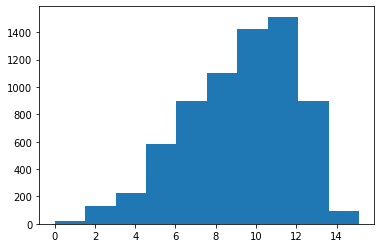

In [498]:
plt.hist(np.log(lcp_single_train['tf_lemma'].astype(float)+1))

Log TF Lemma, All

In [980]:
train(lcp_single_train, lcp_single_dev, 'All', 'TF Lemma', log_tf_lemma=True, bin_tf_lemma=False)

(0.07844633851109216, 0.6487464442744307, 0.6015857082002666)

Glove + ... + Log TF Lemma, All

In [1030]:
train(lcp_single_train, lcp_single_dev, 'All', ['Glove word','TF Summed BPE','TF Lemma'], log_tf_lemma=True, bin_tf_lemma=False)

(0.06918062096598929, 0.7586155677188414, 0.7111267368701762)

In [1018]:
# just log (no bin) 800 random
print(history.mean(), history.std())

0.0703943005727202 0.0016440490437032017


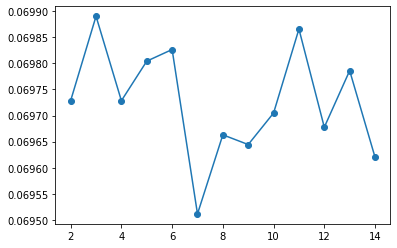

In [1040]:
# 400 random
i = len(history)
means = history[:i].mean(axis=0)
stds = history[:i].std(axis=0)
plt.scatter(n_bins_lst, means); plt.plot(n_bins_lst, means)

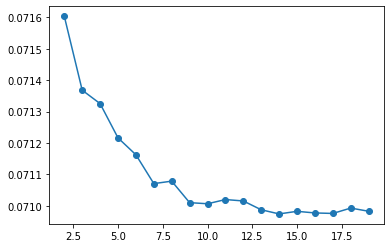

In [610]:
# 100 random
i = len(history)
means = history[:i].mean(axis=0)
stds = history[:i].std(axis=0)
plt.scatter(n_bins_lst, means); plt.plot(n_bins_lst, means)

TF Summed BPE, All

In [984]:
train(lcp_single_train, lcp_single_dev, 'All', 'TF Summed BPE', log_tf_summed_bpe=False, bin_tf_summed_bpe=False)

(0.10097408998299508, 0.161148487316691, 0.23258453763737405)

In [624]:
train_tf_summed_bpe = pd.read_csv('./data/from_discovery_or_colab/lcp_single_train_tf_summed_bpe.tsv', sep='\t', index_col=0)
dev_tf_summed_bpe = pd.read_csv('./data/from_discovery_or_colab/lcp_single_dev_tf_summed_bpe.tsv', sep='\t', index_col=0)

In [224]:
train_tf_summed_bpe[['token', 'tf_summed_bpe']].to_csv('train_tf_summed_bpe.txt', sep='\t', index=False)
dev_tf_summed_bpe[['token', 'tf_summed_bpe']].to_csv('dev_tf_summed_bpe.txt', sep='\t', index=False)

In [625]:
x = train_tf_summed_bpe['tf_summed_bpe'].to_numpy()

(array([  14.,  137.,  475., 1110., 1479., 1562.,  921.,  589.,  101.,
         497.]),
 array([ 4.62497281,  5.98905026,  7.35312771,  8.71720516, 10.08128261,
        11.44536006, 12.80943751, 14.17351496, 15.53759241, 16.90166986,
        18.26574731]),
 <BarContainer object of 10 artists>)

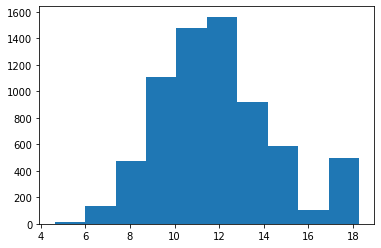

In [627]:
plt.hist(np.log(x))

Log TF Summed BPE, All

In [985]:
train(lcp_single_train, lcp_single_dev, 'All', 'TF Summed BPE', log_tf_summed_bpe=True, bin_tf_summed_bpe=False)

(0.09985207307781098, 0.2747671820315609, 0.23258453763737405)

Glove word + TF Summed BPE, All

In [987]:
train(lcp_single_train, lcp_single_dev, 'All', ['Glove word', 'TF Summed BPE'], log_tf_summed_bpe=False, bin_tf_summed_bpe=False)

(0.0702071252966171, 0.7447297480328822, 0.7083077206596999)

In [173]:
model = train(lcp_single_train, lcp_single_dev, 'All', ['Glove word', 'TF Summed BPE'])

debug
debug


In [ ]:
model.coef_

Glove word + Log TF Summed BPE, All

In [988]:
train(lcp_single_train, lcp_single_dev, 'All', ['Glove word', 'TF Summed BPE'], log_tf_summed_bpe=True, bin_tf_summed_bpe=False)

(0.0696964482632254, 0.7497414016042219, 0.7107261316012826)

In [989]:
best_n_bins, best = None, None
n_bins_lst, MAE_lst, pearson_lst, spearman_lst = range(2, 30), [], [], []
for n_bins in tqdm(n_bins_lst):
    #print('n_bins: {}'.format(n_bins))
    result=train(lcp_single_train, lcp_single_dev, 'All', ['Glove word','TF Summed BPE'], log_tf_summed_bpe=True, bin_tf_summed_bpe=True, n_bins_tf_summed_bpe=n_bins, strategy_tf_summed_bpe='quantile')
    MAE_lst.append(result[0]); pearson_lst.append(result[1]); spearman_lst.append(result[2])
    #print(result)
    if not best or result[0] < best:
        best_n_bins, best = n_bins, result[0]
print('best_n_bins: {}, best: {}'.format(best_n_bins, best))

100%|██████████| 28/28 [00:15<00:00,  1.77it/s]best_n_bins: 3, best: 0.06916571644757268



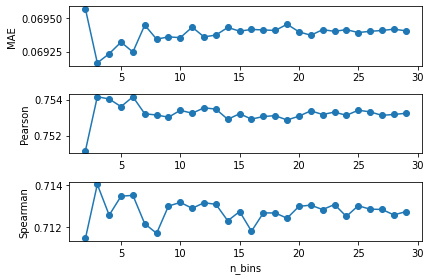

In [990]:
plt.subplot(3,1,1)
plt.ylabel('MAE')
plt.scatter(n_bins_lst, MAE_lst); plt.plot(n_bins_lst, MAE_lst)
plt.subplot(3,1,2)
plt.ylabel('Pearson')
plt.scatter(n_bins_lst, pearson_lst); plt.plot(n_bins_lst, pearson_lst)
plt.subplot(3,1,3)
plt.xlabel('n_bins'); plt.ylabel('Spearman')
plt.scatter(n_bins_lst, spearman_lst); plt.plot(n_bins_lst, spearman_lst)
plt.tight_layout()

In [1031]:
#save = history
history = []
#history = save

In [1036]:
combined = lcp_single_train.append(lcp_single_dev)
for i in tqdm(range(300)):
    train_df = pd.DataFrame(columns=combined.columns)
    dev_df = pd.DataFrame(columns=combined.columns)
    for (corpus, cls), group in combined.groupby(['corpus','class']):
        if len(group) == 2:
            t = group.iloc[0:1]
            d = group.iloc[1:2]
        else:
            t, d = train_test_split(group, test_size=0.1)
        train_df = train_df.append(t)
        dev_df = dev_df.append(d)
    best_n_bins, best = None, None
    n_bins_lst, MAE_lst = range(2, 15), []
    
    #for n_bins in tqdm(n_bins_lst):
    for n_bins in n_bins_lst:
        #print('n_bins: {}'.format(n_bins))
        #result=train(train_df, dev_df, 'All', ['Glove word', 'TF Summed BPE'], log_tf_summed_bpe=True, bin_tf_summed_bpe=True, n_bins_tf_summed_bpe=n_bins, strategy_tf_summed_bpe='quantile')
        result=train(train_df, dev_df, 'All', ['Glove word', 'TF Summed BPE', 'TF Lemma'], log_tf_lemma=True, bin_tf_lemma=True, n_bins_tf_lemma=n_bins, strategy_tf_lemma='quantile')
        MAE_lst.append(result[0])
        #print(result)
        if not best or result[0] < best:
            best_n_bins, best = n_bins, result[0]
    #MAE_lst.append(train(train_df, dev_df, 'All', ['Glove word','TF Summed BPE','TF Lemma'], log_tf_lemma=True, bin_tf_summed_bpe=False)[0])
    history.append(MAE_lst)
    #break

100%|██████████| 300/300 [19:22<00:00,  3.88s/it]


In [1037]:
history = np.array(history)
#history = [item.tolist() for item in history]

0.07110221782138267 0.0017974975920698006


(array([  2.,  20.,  69., 111., 166., 176., 130.,  79.,  35.,  12.]),
 array([0.06574367, 0.06677678, 0.06780989, 0.068843  , 0.06987611,
        0.07090922, 0.07194233, 0.07297544, 0.07400855, 0.07504166,
        0.07607477]),
 <BarContainer object of 10 artists>)

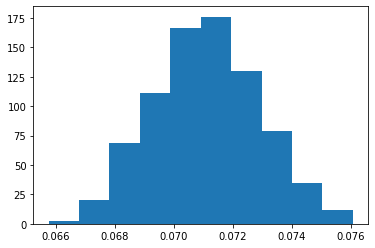

In [997]:
# just log (no bin) 800 random
print(history.mean(), history.std())
plt.hist(history)

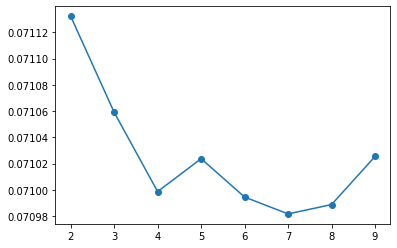

In [1003]:
# 400 random
i = len(history)
means = history[:i].mean(axis=0)
stds = history[:i].std(axis=0)
plt.scatter(n_bins_lst, means); plt.plot(n_bins_lst, means)

(array([45., 57., 75., 47., 45., 78., 53.]),
 array([2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 7 artists>)

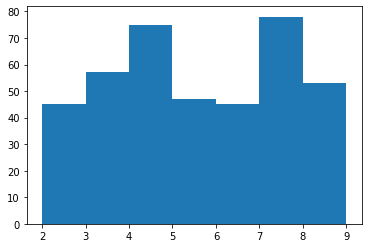

In [1007]:
plt.hist(np.argmin(history, axis=1)+2, bins=range(2, 10))

n_bins = 7

Playground

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer.fit(corpus)
tfidf_vectorizer.fit(corpus)

TfidfVectorizer()

In [50]:
result = count_vectorizer.transform(['And this document, this is third.'])
result[0].toarray()

array([[1, 1, 0, 1, 0, 0, 0, 1, 2]])

In [51]:
result = tfidf_vectorizer.transform(['And this document, this is third.'])
result[0].toarray()

array([[0.51509432, 0.32877803, 0.        , 0.26879758, 0.        ,
        0.        , 0.        , 0.51509432, 0.53759516]])

In [22]:
result = vectorizer.transform(lcp_single_train['sentence'])
lcp_single_train['idx'] = range(len(lcp_single_train))
lcp_single_train['tf'] = lcp_single_train.apply(lambda x: result[x['idx'], vectorizer.vocabulary_[x['token']]], axis=1)

KeyError: 'servants'

In [13]:
result = vectorizer.transform(lcp_single_train['sentence'])
lcp_single_train['idx'] = range(len(lcp_single_train))
lcp_single_train['tfidf'] = lcp_single_train.apply(lambda x: get_tfidf_for_sample(x, vectorizer, result), axis=1)

In [12]:
def get_tfidf_for_sample(x, v, r, default=1):
    idx = x['idx']
    token = x['token']
    if token in v.vocabulary_:
        return r[idx, v.vocabulary_[token]]
    else:
        if v.lowercase:
            token = token.lower()
            if token in v.vocabulary_:
                return r[idx, v.vocabulary_[token]]
            else:
                return default
        else:
            return default

In [8]:
lcp_single_train = pkl.load(open('./data/lcp_single_train.pkl', 'rb'))

In [9]:
folder_path = './data/gigaword_eng_baby/nyt'

In [14]:
external_paragraphs = []
for file_name in tqdm(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
        soup = BeautifulSoup(file, "html.parser")
        # Iterate over all <p> items and get the text for each.
        for paragraph in soup("p"):
            # Turn inter-paragraph newlines into spaces
            paragraph = paragraph.get_text()
            paragraph = re.sub(r"\n+", "\n", paragraph)
            paragraph = paragraph.replace("\n", " ")
            external_paragraphs.append(paragraph)

 54%|█████▍    | 52/96 [30:34<25:51, 35.27s/it]


KeyboardInterrupt: 

In [15]:
len(external_paragraphs)

12345130

In [182]:
output_path = './data/gigaword_nyt.txt'
with open(output_path, 'w') as file:
    for paragraph in external_paragraphs:
        file.write('{}\n'.format(paragraph))

In [ ]:
!cd ./data/stanford-corenlp-4.2.0/
!java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -preload tokenize,ssplit,pos,lemma,ner,parse,depparse -status_port 9000 -port 9000 -timeout 15000000 & 
!cd ../..
# ps aux | grep StanfordCoreNLPServer

In [330]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser(url='http://localhost:9000')

In [153]:
lcp_single_train = pkl.load(open('./data/lcp_single_train.pkl', 'rb'))

In [154]:
conversion = {'‚Ä†':'†', '¬∞':'°', '¬¢':'¢', '¬£':'£', '¬ß':'§', '‚Ä¢':'•', '¬∂':'¶', '¬Æ':'®', '¬©':'©', '‚Ñ¢':'™', '¬¥':'´', '¬®':'¨', '‚â†':'≠', '‚àû':'∞', '¬±':'±', '‚â§':'≤', '‚â•':'≥', '¬•':'¥', '‚àÇ':'∂', '‚àë':'∑', '‚àè':'∏', '‚à´':'∫', '¬ø':'¿', '¬°':'¡', '¬¨':'¬', '‚àö':'√', '‚âà':'≈', '‚àÜ':'∆', '¬´':'«', '¬ª':'»', '‚Ä¶':'…', '‚Äì':'–', '‚Äî':'—', '‚Äú':'“', '‚Äù':'”', '‚Äò':'‘', '‚Äô':'’', '√∑':'÷', '‚óä':'◊', '‚ÅÑ':'⁄', '‚Ç¨':'€', '‚Äπ':'‹', '‚Ä∫':'›', '‚Ä°':'‡', '¬∑':'·', '‚Äö':'‚', '‚Äû':'„', '‚Ä∞':'‰', 'ÀÜ':'ˆ', 'Àú':'˜', '¬Ø':'¯', 'Àò':'˘', 'Àô':'˙', 'Àö':'˚', '¬∏':'¸', 'Àù':'˝', 'Àõ':'˛', 'Àá':'ˇ', '¬™':'ª', '√°':'á', '√Å':'Á', '√†':'à', '√Ä':'À', '√¢':'â', '√Ç':'Â', '√Ö':'Å', '√•':'å', '√Ñ':'Ä', '√§':'ä', '√£':'ã', '√É':'Ã', '√Ü':'Æ', '√¶':'æ', '√á':'Ç', '√ß':'ç', '√â':'É', '√©':'é', '√®':'è', '√à':'È', '√™':'ê', '√ä':'Ê', '√´':'ë', '√ã':'Ë', 'Ô¨Å':'ﬁ', 'Ô¨Ç':'ﬂ', '∆í':'ƒ', '√≠':'í', '√ç':'Í', '√¨':'ì', '√å':'Ì', '√Æ':'î', '√é':'Î', '√Ø':'ï', '√è':'Ï', 'ƒ±':'ı', '√ë':'Ñ', '√±':'ñ', '¬∫':'º', '√≥':'ó', '√ì':'Ó', '√≤':'ò', '√í':'Ò', '√¥':'ô', '√î':'Ô', '√ñ':'Ö', '√∂':'ö', '√µ':'õ', '√ï':'Õ', '≈í':'Œ', '≈ì':'œ', '√ò':'Ø', '√∏':'ø', '√ü':'ß', '√∫':'ú', '√ö':'Ú', '√π':'ù', '√ô':'Ù', '√ª':'û', '√õ':'Û', '√ú':'Ü', '√º':'ü', '√ø':'ÿ', '≈∏':'Ÿ', '¬µ':'µ', 'œÄ':'π', 'Œ©':'Ω', 'Œ±':'α', '     ':'', '‚àí':'−', 'Œ≤':'β', 'Œî':'Δ', '√ó':'×', 'Œ¥':'δ', 'Œº':'μ', 'for   CCAAT':'forCCAAT', '(‚“':'(“', '‚”)':'”)', 'Œ≥':'γ'}

In [155]:
def clean_sentence(sentence, conversion_dict):
    result = sentence
    for char_old, char_new in conversion_dict.items():
        result = result.replace(char_old, char_new)
    # this duplicate is not a type-o :)
    for char_old, char_new in conversion_dict.items():
        result = result.replace(char_old, char_new)
    result = result.replace('%', '%25')
    return result

In [156]:
lcp_single_train['sentence'] = lcp_single_train['sentence'].apply(lambda x: clean_sentence(x, conversion))

In [335]:
# perhaps should be deprecated; I discovered increasing timeout parameter for server helps!
# good to remember these type of sentences (many clauses, extremely long, etc.)
exceptions = {'3KA7IJSNW65H9AJU8WQWUQHUT94PBQ': 'the report by Fausto Correira, on behalf of the Committee on Civil Liberties, Justice and Home Affairs, on the initiative by the Kingdom of Belgium, the Republic of Bulgaria, the Federal Republic of Germany, the Kingdom of Spain, the French Republic, the Grand Duchy of Luxembourg, the Kingdom of the Netherlands, the Republic of Austria, the Republic of Slovenia, the Slovak Republic, the Italian Republic, the Republic of Finland, the Portuguese Republic, Romania and the Kingdom of Sweden on the stepping up of cross-border cooperation, particularly in combating terrorism and cross-border crime', '3CMIQF80GNQW3A3ECIODJFLCK5WQ6G': "the oral question to the Commission (B7-0239/2009) by Licia Ronzulli, Giovanni Collino, Marco Scurria, Giancarlo Scotta', Potito Salatto, Pablo Arias Echeverría, Raffaele Baldassarre, Pilar Ayuso, Luis de Grandes Pascual, Pilar del Castillo Vera, Santiago Fisas Ayxela, Carmen Fraga Estévez, Salvador Garriga Polledo, Cristina Gutiérrez-Cortines, Esther Herranz García, Carlos José Iturgaiz Angulo, Veronica Lope Fontagné, Antonio López-Istúriz White, Gabriel Mato Adrover, Jaime Mayor Oreja, Pablo Zalba Bidegain, Salvatore Tatarella, Magdi Cristiano Allam, Mirosław Piotrowski and Konrad Szymański, on the display of religious and cultural symbols in public places.", '3CVDZS288H011OYXLIK0WCEK32MFM3':"the report by Georg Jarzembowski on behalf of the European Parliament Delegation to the Conciliation Committee on the joint text approved by the Conciliation Committee for a directive of the European Parliament and of the Council amending Council Directive 91/440/EEC on the development of the Community's railways and Directive 2001/14/EEC of the European Parliament and of the Council on the allocation of railway infrastructure capacity and the levying of charges for the use of railway infrastructure (PE-CONS 3635/2007, and", '36MUZ9VAE626RGSODE1RV46QINFED2':"A4-0124/97 by Mr Wynn, on behalf of the Committee on Budgetary Control on the Commission report (COM(97)0048 - C4-0108/97) on the measures taken to follow up the observations contained in the European Parliament's resolution accompanying the discharge decision in respect of the implementation of the general budget of the European Communities for the 1994 financial year; -A4-0120/97 by Mr Wynn, on behalf of the Committee on Budgetary Control, giving discharge to the Commission in respect of the implementation of the general budget of the European Communities for the 1995 financial year - Section III; -A4-0125/97 by Mr Dankert, on behalf of the Committee on Budgetary Control, giving discharge to the Commission in respect of the implementation of the general budget of the European Communities for the 1995 financial year - Sections I, IV, V and VI;"}

In [340]:
y = []
silence = True
for idx, row in tqdm(lcp_single_train.iterrows()):
    if idx == 7579:
        silence = False
    if silence:
        continue
    if row['id'] in exceptions:
        sentence = exceptions[row['id']]
    else:
        sentence = row['sentence']
    y.append(next(parser.raw_parse(sentence)))

6885it [05:03, 22.72it/s]


In [309]:
sentence, row['token'], row['complexity']

("A4-0124/97 by Mr Wynn, on behalf of the Committee on Budgetary Control on the Commission report (COM(97)0048 - C4-0108/97) on the measures taken to follow up the observations contained in the European Parliament's resolution accompanying the discharge decision in respect of the implementation of the general budget of the European Communities for the 1994 financial year; -A4-0120/97 by Mr Wynn, on behalf of the Committee on Budgetary Control, giving discharge to the Commission in respect of the implementation of the general budget of the European Communities for the 1995 financial year - Section III; -A4-0125/97 by Mr Dankert, on behalf of the Committee on Budgetary Control, giving discharge to the Commission in respect of the implementation of the general budget of the European Communities for the 1995 financial year - Sections I, IV, V and VI; -A4-0071/97 by Mr Blak, on behalf of the Committee on Budgetary Control, giving discharge to the Commission in respect of the management of t

In [ ]:
lcp_single_train

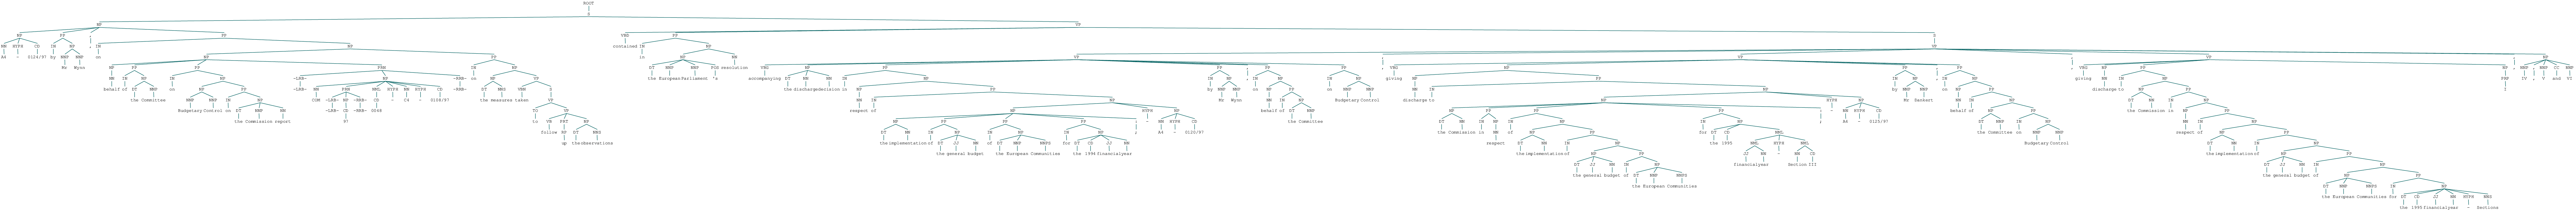

In [332]:
next(parser.raw_parse("A4-0124/97 by Mr Wynn, on behalf of the Committee on Budgetary Control on the Commission report (COM(97)0048 - C4-0108/97) on the measures taken to follow up the observations contained in the European Parliament's resolution accompanying the discharge decision in respect of the implementation of the general budget of the European Communities for the 1994 financial year; -A4-0120/97 by Mr Wynn, on behalf of the Committee on Budgetary Control, giving discharge to the Commission in respect of the implementation of the general budget of the European Communities for the 1995 financial year - Section III; -A4-0125/97 by Mr Dankert, on behalf of the Committee on Budgetary Control, giving discharge to the Commission in respect of the implementation of the general budget of the European Communities for the 1995 financial year - Sections I, IV, V and VI;"))

In [333]:
idx

7579

In [334]:
lcp_single_train.loc[7579]

id                               36MUZ9VAE626RGSODE1RV46QINFED2
corpus                                                 europarl
sentence      A4-0124/97 by Mr Wynn, on behalf of the Commit...
token                                                        VI
complexity                                             0.485294
class                                                         3
Name: 7579, dtype: object

In [341]:
len(y)

106

In [343]:
parse_lst.extend(y)

In [344]:
len(parse_lst)

6885

In [345]:
#with open('./data/parse_lst_6885.pkl', 'wb') as f:
#    pkl.dump(parse_lst, f)

In [1055]:
parse_lst = pkl.load(open('./data/parse_lst_6885.pkl', 'rb'))

In [55]:
def token_depth(parse, token):
    n_leaves = len(parse.leaves())
    leavepos = set(parse.leaf_treeposition(n) for n in range(n_leaves))
    for pos in parse.treepositions():
        if pos in leavepos and parse[pos] == token:
            return len(pos)
    else:
        print('foo')
        return np.nan

In [56]:
def num_words_at_depth(parse, depth):
    n_leaves = len(parse.leaves())
    leavepos = set(parse.leaf_treeposition(n) for n in range(n_leaves))
    result = 0
    for pos in parse.treepositions():
        if pos in leavepos and len(pos) == depth:
            result += 1
    return result

In [57]:
tokens = lcp_single_train['token'].iloc[:len(parse_lst)].tolist()

In [58]:
parse_tree_depths = []
token_depths = []
num_words_at_depths = []
for parse, token in tqdm(zip(parse_lst, tokens)):
    parse_tree_depths.append(parse.height())
    token_depths.append(token_depth(parse, token))
    num_words_at_depths.append(num_words_at_depth(parse, token_depths[-1]))

3510it [00:22, 162.80it/s]foo
6885it [00:50, 137.21it/s]


In [59]:
lcp_single_train['parse_tree_depth'] = np.nan
lcp_single_train['token_depth'] = np.nan
lcp_single_train['num_words_at_depth'] = np.nan
lcp_single_train['parse_tree_depth'].iloc[:len(parse_lst)] = parse_tree_depths
lcp_single_train['token_depth'].iloc[:len(parse_lst)] = token_depths
lcp_single_train['num_words_at_depth'].iloc[:len(parse_lst)] = num_words_at_depths
lcp_single_train[['complexity', 'parse_tree_depth', 'token_depth', 'num_words_at_depth']].corr()

complexity  parse_tree_depth  token_depth  \
complexity            1.000000          0.016662     0.041726   
parse_tree_depth      0.016662          1.000000     0.639265   
token_depth           0.041726          0.639265     1.000000   
num_words_at_depth    0.052917          0.020917    -0.076260   

                    num_words_at_depth  
complexity                    0.052917  
parse_tree_depth              0.020917  
token_depth                  -0.076260  
num_words_at_depth            1.000000

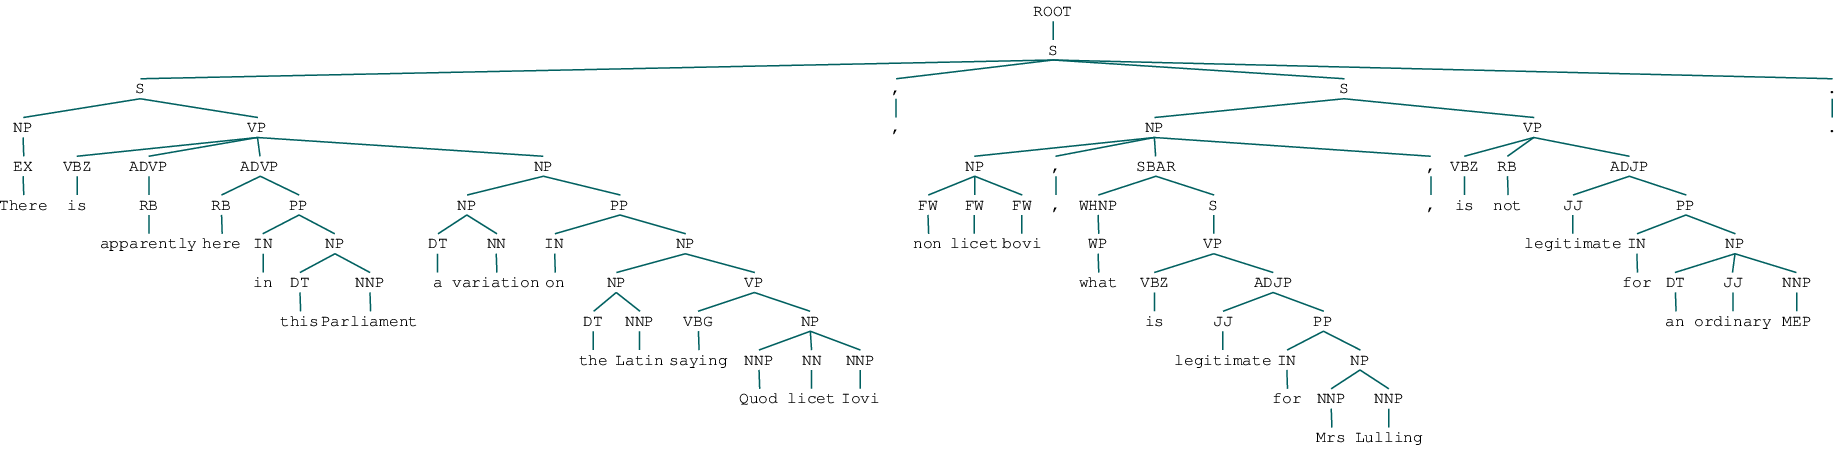

In [373]:
parse_lst[6883]

In [378]:
lcp_single_train.iloc[6883][['sentence', 'token']]

sentence    There is apparently here in this Parliament a ...
token                                                    Quod
Name: 7660, dtype: object

In [377]:
parse = parse_lst[6883]
parse_tree_depths[6883], token_depths[6883], num_words_at_depths[6883]

(12, 10, 4)

In [ ]:
from nltk.tree import Tree
Tree.fromstring(str(parse)).pretty_print()

In [381]:
from nltk.tree import ParentedTree

In [382]:
parse_parented = ParentedTree.convert(parse)

In [396]:
parse_parented[pos]

'Quod'

In [395]:
n_leaves = len(parse.leaves())
leavepos = set(parse.leaf_treeposition(n) for n in range(n_leaves))
for pos in parse.treepositions():
    if pos in leavepos and len(pos) == 10:
        print(parse[pos], len(pos))
        break

Quod 10


In [257]:
for corpus_name, corpus in lcp_single_train.groupby('corpus'):
    corpus['is_pronoun'] = corpus['token'].apply(lambda x: x[0].isupper())
    corpus = corpus[~corpus['is_pronoun']] # ignore pronouns, which are harder to predict
    corpus['word_freq'], corpus['word_len'], corpus['syl_count'] = handcrafted(corpus)
    print(corpus[['complexity','word_freq', 'word_len', 'syl_count']].corr())

            complexity  word_freq  word_len  syl_count
complexity    1.000000  -0.306259  0.329347   0.340086
word_freq    -0.306259   1.000000 -0.308867  -0.255821
word_len      0.329347  -0.308867  1.000000   0.834331
syl_count     0.340086  -0.255821  0.834331   1.000000
            complexity  word_freq  word_len  syl_count
complexity    1.000000  -0.383796  0.173813   0.215285
word_freq    -0.383796   1.000000 -0.345354  -0.297218
word_len      0.173813  -0.345354  1.000000   0.858449
syl_count     0.215285  -0.297218  0.858449   1.000000
            complexity  word_freq  word_len  syl_count
complexity    1.000000  -0.376786  0.323285   0.326064
word_freq    -0.376786   1.000000 -0.446586  -0.418285
word_len      0.323285  -0.446586  1.000000   0.873333
syl_count     0.326064  -0.418285  0.873333   1.000000


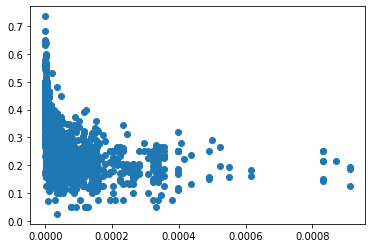

In [261]:
plt.scatter(corpus['word_freq'], corpus['complexity'])

In [293]:
corpus[corpus.duplicated('token', keep=False)].sort_values('token').groupby('token')['complexity'].apply(lambda x: max(x)- min(x)).sort_values(ascending=False)

token
defence         0.300000
statements      0.284524
products        0.269444
suffrage        0.250000
climate         0.250000
                  ...   
politicians     0.001548
directive       0.000735
views           0.000000
interpreters    0.000000
coordinators    0.000000
Name: complexity, Length: 331, dtype: float64

In [271]:
pd.set_option('display.max_colwidth', -1)

In [295]:
corpus[corpus['token']=='statements'][['sentence', 'complexity', 'class']].sort_values('complexity')

sentence  \
5162  The report, which is short on statements, is an important step in regulating and facilitating our cooperation with our significant neighbour, Ukraine.             
5163  This will be followed by a statement from the Vice-President of the Commission and then short statements on behalf of the political groups.                        
5164  Mr President, I am asking for the floor under Rule 145 on personal statements, which allows me to speak for up to three minutes; I will not take that much time.   
5165  The next item is the Council and Commission statements on the situation in Honduras.                                                                               
5166  The next item is the Council and Commission statements on climate change and energy.                                                                               

      complexity class  
5162  0.025000    1     
5163  0.200000    1     
5164  0.250000    2     
5165  0.264706    2     
5166  0.309524    2

In [330]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
sentence = 'Mr President, I am asking for the floor under Rule 145 on personal statements, which allows me to speak for up to three minutes; I will not take that much time.'
token = 'statements'
tokens = tokenizer.tokenize(sentence)
token_idx = tokens.index(token)
window = 2
score = np.mean([wordfreq.word_frequency(tokens[idx], 'en') for idx in range(max(0, token_idx-window), min(len(tokens)-1, token_idx+window+1)) if idx != token_idx])
score

0.0026805250000000004

In [68]:
lcp_single_train.head()

id corpus  \
218  3UUSLRKAUL3LI1DEQ6NLPUE9WZQD7S  bible   
877  3VDI8GSXAFTSUZSO21GZ9FD1KBC8GK  bible   
415  344M16OZKIFFDSJ128FUR9IKWQ1EN2  bible   
309  39XCQ6V3KY47AOKGSQ0AL4QLO7856D  bible   
502  3S8APUMBJXJ5IXU0UTURIW3QR0XFBN  bible   

                                              sentence      token  complexity  \
218  Haman recounted to them the glory of his riche...   servants    0.176471   
877  As they were making their hearts merry, behold...     hearts    0.191176   
415     How much better it is to get wisdom than gold!     wisdom    0.142857   
309  The sun will be darkened in its going forth, a...      light    0.181818   
502  being approved by good works, if she has broug...  strangers    0.132353   

    class  word_len  sentence_len  
218     1         8           202  
877     1         6           274  
415     1         6            46  
309     1         5            92  
502     1         9           225

In [66]:
lcp_single_train['word_len'] = lcp_single_train.apply(lambda x: len(x['token']), axis=1)
lcp_single_train['sentence_len'] = lcp_single_train.apply(lambda x: len(x['sentence']), axis=1)

In [67]:
lcp_single_train[['complexity', 'word_len', 'sentence_len']].corr()

complexity  word_len  sentence_len
complexity      1.000000  0.095143      0.063823
word_len        0.095143  1.000000      0.094663
sentence_len    0.063823  0.094663      1.000000

In [406]:
lcp_single_train = pkl.load(open('./data/lcp_single_train.pkl', 'rb'))

In [399]:
lcp_single_train['word_freq'], lcp_single_train['word_len'], lcp_single_train['syl_count'] = handcrafted(lcp_single_train)

In [53]:
lcp_single_train['is_pronoun'] = lcp_single_train['token'].apply(lambda x: x[0].isupper())

In [57]:
lcp_single_train[~lcp_single_train['is_pronoun']][['complexity', 'word_freq', 'word_len', 'syl_count']].corr()

complexity  word_freq  word_len  syl_count
complexity    1.000000  -0.344335  0.247871   0.273094
word_freq    -0.344335   1.000000 -0.336613  -0.291339
word_len      0.247871  -0.336613  1.000000   0.862937
syl_count     0.273094  -0.291339  0.862937   1.000000

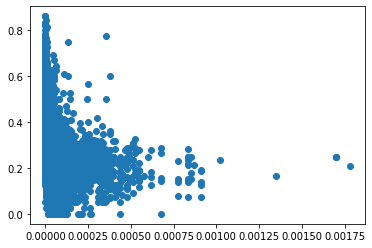

In [61]:
plt.scatter(lcp_single_train['word_freq'], lcp_single_train['complexity'])

In [ ]:
# Write your code here
ranks = {}
rank, prev = 0, None
for i, high_score in enumerate(ranked):
    if not prev or prev != high_score:
        rank += 1
    ranks[i] = rank
    prev = ranked[i]

result = []
score = player[0]
for i, high_score in enumerate(ranked):
    if score >= high_score:
        result.append(ranks[i])
        break
else:
    result.append(ranks[len(ranked)-1]+1)

In [339]:
[1,2,3,4][::-1]

[4, 3, 2, 1]

In [354]:
def leftmostMaxIndex(array):
    largest = None
    largest_i = len(array)-1
    for i in range(len(array)-1, -1, -1):
        if not largest or array[i] >= largest:
            largest, largest_i = array[i], i
    return largest_i

In [370]:
packages = [1,2,3]
# Write your code here
lmi = leftmostMaxIndex(packages)
packages[lmi:]

[3]

In [371]:
sorted(enumerate(packages), key=lambda x: x[1], reverse=True)

[(2, 3), (1, 2), (0, 1)]

In [369]:
sorted(enumerate(packages), key=lambda x: x[1], reverse=True)

[(0, 7), (2, 7), (1, 4)]

In [ ]:
lmi = leftmostMaxIndex(packages)
while lmi == 0 and packages[0] == 0:
    move_time = len(packages)+1-lmi 
    grab_time = 